In [2]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
from itertools import compress
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

Valid orders within 6 months in DE Shop (from 01/05/2018 to 30/11/2018) with a TC mapping

### Data loading, cleaning & formatting

In [2]:
data = pd.read_csv('6_months_orders_de_shop_blacklisting_patterns_v2.dsv', sep=';', low_memory=False)

In [3]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ
0,467651111,01/05/2018 09:43:19,109775002,6723847,297248,2365619,1,60516,"9,89","36,72",50,35759
1,467651113,01/05/2018 09:43:19,109775002,6723847,297248,2365516,1,60598,"9,89","36,72",50,35759
2,467651114,01/05/2018 09:43:19,109775002,6723847,297248,2069708,2,64938,"4,49","36,72",50,35759
3,467651116,01/05/2018 09:43:20,109775003,9353414,4249863,1548141,2,64539,"4,99","46,41",51,47051
4,467651117,01/05/2018 09:43:20,109775003,9353414,4249863,2116423,2,72699,"4,99","46,41",51,47051


In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393548 entries, 0 to 18393547
Data columns (total 12 columns):
OP_ID               int64
O_DATE              object
O_ID                int64
O_K_ID              int64
TC_ID               int64
OP_AS_ID            int64
OP_AMOUNT           int64
APS_AP_ID           int64
OP_PRICE            object
O_GWERT             object
OSP_KO_COUNT_NET    int64
OCI_PLZ             object
dtypes: int64(8), object(4)
memory usage: 1.6+ GB


In [5]:
# check duplicates at an order position level 6_months_orders_es_shop_blacklisting_patterns_v2.dsv

In [6]:
data = data[~data['OP_ID'].duplicated()]

In [7]:
data[~data['OP_ID'].duplicated()]['OP_ID'].nunique(), len(data)

(16284034, 16284034)

In [8]:
data['O_DATE'] = pd.to_datetime(data['O_DATE'], format="%d/%m/%Y %H:%M:%S")

In [9]:
data['O_DATE'].min(), data['O_DATE'].max()

(Timestamp('2018-05-01 00:00:10'), Timestamp('2018-11-30 23:59:59'))

In [10]:
data['OP_PRICE'] = [float(str(i).replace(',','.')) for i in data['OP_PRICE'].values]
data['O_GWERT'] = [float(str(i).replace(',','.')) for i in data['O_GWERT'].values]

In [11]:
data['OCI_PLZ'] = [str(i).replace(' ', '') for i in data['OCI_PLZ'].values]

In [12]:
data['MAX_SALES_O_POS'] = data['OP_PRICE'].groupby(data['O_ID']).transform('max')
data['IS_LEAD_AS'] = (data['OP_PRICE'] == data['MAX_SALES_O_POS']) * 1 * data['OP_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['O_ID']).transform('max')

In [13]:
arts_to_pgs = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [14]:
arts_to_pgs = arts_to_pgs.fillna(0).astype(int)[['AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']]
arts_to_pgs.head()

,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,7,3,33,1053
1,28,418,1248,1261
2,33,2,15,94
3,40,6,1635,1664
4,41,6,1635,3116


In [15]:
data = data.merge(arts_to_pgs, left_on='APS_AP_ID', right_on='AP_ID', how='left')

In [16]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ,MAX_SALES_O_POS,IS_LEAD_AS,LEAD_AS_ID,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,467651111,2018-05-01 09:43:19,109775002,6723847,297248,2365619,1,60516,9.89,36.72,50,35759,9.89,2365619,2365619,60516.0,3.0,2068.0,129282.0
1,467651113,2018-05-01 09:43:19,109775002,6723847,297248,2365516,1,60598,9.89,36.72,50,35759,9.89,2365516,2365619,60598.0,3.0,2068.0,129282.0
2,467651114,2018-05-01 09:43:19,109775002,6723847,297248,2069708,2,64938,4.49,36.72,50,35759,9.89,0,2365619,64938.0,3.0,301.0,97754.0
3,467651116,2018-05-01 09:43:20,109775003,9353414,4249863,1548141,2,64539,4.99,46.41,51,47051,4.99,1548141,2116433,64539.0,3.0,2068.0,2127.0
4,467651117,2018-05-01 09:43:20,109775003,9353414,4249863,2116423,2,72699,4.99,46.41,51,47051,4.99,2116423,2116433,72699.0,3.0,2068.0,2127.0


In [17]:
data[['OP_AMOUNT', 'OSP_KO_COUNT_NET', 'LEAD_AS_ID', 'AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']] = \
data[['OP_AMOUNT', 'OSP_KO_COUNT_NET', 'LEAD_AS_ID', 'AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

### Order level

In [18]:
#Operations to do when grouping at order level
agg_ops = {'O_DATE': min,
          'O_K_ID': min, 
          'TC_ID': min,
          'OSP_KO_COUNT_NET': min,
          'O_GWERT': max,
          'APS_AP_ID': lambda x: list(x),
          'OP_AS_ID': [len, lambda x: list(x)],
          'OP_AMOUNT': lambda x: list(x),
          'LEAD_AS_ID': max,
          'L2_PG_ID': max,
          'L3_PG_ID': max,
          'L4_PG_ID': max,
          'OCI_PLZ': lambda x: list(set(list(x)))
          }

In [19]:
orders = data.groupby('O_ID', as_index=False).agg(agg_ops)

In [20]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [21]:
orders.columns = ['O_ID', 'O_DATE', 'O_K_ID', 'TC_ID', 'OSP_KO_COUNT_NET',
       'O_GWERT', 'APS_AP_ID_list', 'OP_AS_ID_len',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID',
       'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID', 'OCI_PLZ']

In [22]:
orders.head()

,O_ID,O_DATE,O_K_ID,TC_ID,OSP_KO_COUNT_NET,O_GWERT,APS_AP_ID_list,OP_AS_ID_len,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ
0,109765635,2018-05-01 00:00:19,16083097,11906408,9,27.24,"[21449, 42715, 42225, 62600, 6168]",5,"[1828398, 6, 1996226, 1367342, 2]","[1, 1, 1, 1, 1]",1828398,447,48963,250154,[8301]
1,109765645,2018-05-01 00:01:00,17079963,12591753,3,37.99,"[52690, 42715]",2,"[929397, 6]","[1, 1]",929397,2,251,2108,[58239]
2,109765651,2018-05-01 00:01:37,18563519,8114552,13,125.32,"[74089, 13857, 71629, 73691, 63356, 42225, 781...",10,"[2148265, 1598427, 2037614, 2148068, 1455210, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",2148265,447,48963,10331,[42579]
3,109765659,2018-05-01 00:02:32,1295214,1336200,69,20.92,"[66379, 9795, 71089, 66374, 66382, 26549, 66369]",7,"[1780173, 2300687, 2149707, 1780177, 1780170, ...","[2, 1, 1, 2, 1, 1, 2]",2149707,2047,3156,248782,[12279]
4,109765668,2018-05-01 00:03:54,5517652,4588726,87,63.97,"[58117, 65590, 42715, 52767, 33459, 17543]",6,"[1154089, 1617251, 6, 932803, 2009311, 1783088]","[1, 1, 1, 1, 1, 1]",1783088,3,2068,9616,[1210]


In [23]:
orders['OP_AS_ID_len'] = orders['OP_AS_ID_len'].fillna(0).astype(int)

In [24]:
orders['DATE_N_SV'] = [(i, j) for i, j in list(zip(orders['O_DATE'], orders['O_GWERT']))]

### Customer level

In [25]:
agg_ord_ops = {'O_ID': len,
              'O_DATE': lambda x: list(x),
              'TC_ID': lambda x: list(set(list(x))),
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'O_GWERT': [sum, lambda x: list(np.round(x, 2))],
              'DATE_N_SV': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID': lambda x: list(x),
              'L2_PG_ID': lambda x: list(x),
              'L3_PG_ID': lambda x: list(x),
              'L4_PG_ID': lambda x: list(x),
              'OCI_PLZ': lambda x: [item for sublist in x for item in sublist]
              }

In [26]:
customers_ = orders.groupby('O_K_ID', as_index=False).agg(agg_ord_ops).round(2)

In [27]:
customers_.columns

MultiIndex(levels=[['O_ID', 'O_DATE', 'TC_ID', 'OSP_KO_COUNT_NET', 'O_GWERT', 'DATE_N_SV', 'APS_AP_ID_list', 'OP_AS_ID_len', 'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID', 'OCI_PLZ', 'O_K_ID'], ['<lambda>', 'len', 'sum', '']],
           labels=[[15, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [3, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
customers_.columns = ['_'.join(tup).rstrip('_') for tup in customers_.columns.values]

In [29]:
 customers_.columns = ['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID',
       'OSP_KO_COUNT_NET_list', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list']

In [30]:
customers_['TC_ID'] = [i[0] for i in customers_['TC_ID'].values]

In [31]:
customers_['O_K_COUNTER_MAX'] = [max(i) for i in customers_['OSP_KO_COUNT_NET_list'].values]

In [32]:
customers_.sample(5)

,O_K_ID,O_ID_len,O_DATE_list,TC_ID,OSP_KO_COUNT_NET_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID_list,L2_PG_ID_list,L3_PG_ID_list,L4_PG_ID_list,OCI_PLZ_list,O_K_COUNTER_MAX
547386,14573459,1,[2018-08-14 11:16:37],10860279,[6],23.97,[23.97],"[(2018-08-14 11:16:37, 23.97)]","[[23278, 51176, 6168]]",[3],"[[1890173, 1506561, 2]]","[[1, 1, 1]]",[1506561],[3],[2068],[2127],[16278],6
127275,2419385,1,[2018-10-30 17:07:39],2152357,[35],34.99,[34.99],"[(2018-10-30 17:07:39, 34.99)]",[[82352]],[1],[[2452214]],[[1]],[2452214],[2],[1400],[1413],[59067],35
17451,438115,1,[2018-08-05 14:50:39],725024,[91],26.47,[26.47],"[(2018-08-05 14:50:39, 26.47)]","[[73422, 71344, 74426]]",[3],"[[2156870, 2052811, 2256057]]","[[1, 1, 1]]",[2256057],[3],[1540],[97768],[14552],91
482271,12717213,6,"[2018-05-20 10:18:47, 2018-07-05 15:11:38, 201...",102907,"[60, 61, 62, 63, 64, 65]",467.63,"[133.86, 62.68, 58.39, 93.05, 81.67, 37.98]","[(2018-05-20 10:18:47, 133.86), (2018-07-05 15...","[[56512, 73339, 33229, 26412, 67233, 14616, 27...","[10, 3, 5, 6, 4, 4]","[[1330958, 2364952, 584169, 688463, 1800707, 1...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1], [1...","[1800707, 1800707, 429497, 2326890, 2489081, 5...","[3, 3, 3, 3, 3, 3]","[2068, 2068, 2068, 2068, 2068, 301]","[95904, 95904, 72002, 95904, 95904, 72002]","[8010, 8010, 8010, 8010, 8010, 8010]",65
98476,1858007,3,"[2018-05-08 09:17:17, 2018-06-05 18:57:45, 201...",1696285,"[51, 52, 53]",85.52,"[31.78, 35.14, 18.6]","[(2018-05-08 09:17:17, 31.78), (2018-06-05 18:...","[[68983, 75909, 69510, 72924, 72923, 42715], [...","[6, 2, 3]","[[1868244, 2336390, 2007217, 2133932, 2133933,...","[[1, 1, 1, 1, 1, 1], [1, 1], [1, 1, 1]]","[1868244, 2407986, 480014]","[3, 3, 3]","[207624, 252, 2068]","[294133, 1520, 2078]","[35287, 35287, 35287]",53


### True customer level

In [33]:
mask = [type(i) == list for i in customers_['OCI_PLZ_list'].values]

In [34]:
sum(mask), len(customers_)

(1094696, 1094696)

In [35]:
customers_.columns

Index(['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID', 'OSP_KO_COUNT_NET_list',
       'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list', 'APS_AP_ID_list',
       'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list', 'L4_PG_ID_list',
       'OCI_PLZ_list', 'O_K_COUNTER_MAX'],
      dtype='object')

In [36]:
agg_ord_ops = {'O_ID_len': sum,
              'O_DATE_list': lambda x: list(x),
              'O_K_ID': lambda x: list(x),
              'OSP_KO_COUNT_NET_list': lambda x: list(x),
              'O_K_COUNTER_MAX': lambda x: list(x),
              'O_GWERT_sum': sum, 
              'O_GWERT_list': lambda x: list(x),
              'DATE_N_SV_list': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len_list': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID_list': lambda x: list(x),
              'L2_PG_ID_list': lambda x: list(x),
              'L3_PG_ID_list': lambda x: list(x),
              'L4_PG_ID_list': lambda x: list(x),
              'OCI_PLZ_list': lambda x: list(x)
              }

In [37]:
customers = customers_.groupby('TC_ID', as_index=False).agg(agg_ord_ops).round(2)

In [38]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID', 'OSP_KO_COUNT_NET_list',
       'O_K_COUNTER_MAX', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list',
       'OP_AMOUNT_list', 'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list'],
      dtype='object')

In [39]:
#customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [40]:
customers.columns = ['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID',
       'OCI_PLZ_list']

In [41]:
customers['O_DATE_list'] = [sorted([k for j in i for k in j]) for i in customers['O_DATE_list'].values]

In [42]:
customers['DATE_N_SV_list'] = [sorted([k for j in i for k in j], key=lambda x:x[0]) for i in customers['DATE_N_SV_list'].values]

In [43]:
customers['OSP_KO_COUNT_NET_list'] = [[k for j in i for k in j] for i in customers['OSP_KO_COUNT_NET_list'].values]

In [44]:
customers['O_GWERT_list'] = [[k for j in i for k in j] for i in customers['O_GWERT_list'].values]

In [45]:
customers['OP_AS_ID_len_list'] = [[j for j in i] for i in customers['OP_AS_ID_len_list'].values]

In [46]:
customers['LEAD_AS_ID'] = [Counter([k for j in i for k in j]) for i in customers['LEAD_AS_ID'].values]

In [47]:
customers['L2_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L2_PG_ID'].values]

In [48]:
customers['L3_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L3_PG_ID'].values]

In [49]:
customers['L4_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L4_PG_ID'].values]

In [50]:
customers['OCI_PLZ_list'] = [Counter([k for j in i for k in j]) for i in customers['OCI_PLZ_list'].values]

In [51]:
customers['APS_AP_ID_list'] = [[k for j in i for k in j] for i in customers['APS_AP_ID_list'].values]

In [52]:
customers['OP_AS_ID_len_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_len_list'].values]

In [53]:
customers['OP_AS_ID_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_list'].values]

In [54]:
customers['OP_AMOUNT_list'] = [[k for j in i for k in j] for i in customers['OP_AMOUNT_list'].values]

In [55]:
customers.sample(5)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ_list
282244,2972981,2,"[2018-09-05 15:41:59, 2018-11-05 11:08:24]",[13055474],"[10, 11]",[11],88.95,"[59.99, 28.96]","[(2018-09-05 15:41:59, 59.99), (2018-11-05 11:...","[[49531], [73026, 73026, 74933, 74934]]","[1, 4]","[[787796], [2105595, 2227700, 2224656, 2224655]]","[[1], [1, 1, 1, 1]]","{787796: 1, 2227700: 1}",{3: 2},"{252: 1, 2068: 1}","{13291: 1, 9498: 1}",{'45711': 2}
221368,1938198,11,"[2018-05-08 09:25:05, 2018-07-02 12:01:01, 201...",[2154576],"[41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]",[51],991.82,"[82.72, 107.81, 116.2, 214.78, 79.97, 62.26, 2...","[(2018-05-08 09:25:05, 82.72), (2018-07-02 12:...","[[75357, 68971, 28167, 69009, 8984, 42715], [6...","[6, 7, 6, 5, 2, 6, 4, 8, 2, 3, 2]","[[2220510, 2068037, 1480626, 2068054, 5, 6], [...","[[1, 1, 1, 2, 1, 1], [2, 1, 1, 1, 1, 1, 1], [1...","{2220510: 1, 2068054: 1, 417791: 1, 1531708: 2...","{3: 5, 447: 1, 2: 4, 418: 1}","{2068: 4, 48963: 1, 2155: 1, 251: 4, 9885: 1}","{3155: 3, 2157: 1, 81396: 2, 129145: 2, 250154...","{'81371': 10, '80469': 1}"
781213,13606841,8,"[2018-05-01 18:25:33, 2018-06-01 06:32:02, 201...",[18565836],"[10, 11, 12, 13, 14, 15, 16, 17]",[17],447.13,"[57.98, 42.96, 104.97, 36.98, 61.98, 46.28, 47...","[(2018-05-01 18:25:33, 57.98), (2018-06-01 06:...","[[62951, 70021], [11887, 73187, 50173, 3799], ...","[2, 4, 3, 2, 2, 2, 1, 1]","[[1826010, 2057286], [1516021, 2419887, 208058...","[[1, 1], [1, 1, 1, 1], [1, 1, 1], [1, 1], [1, ...","{2057286: 3, 2419887: 1, 2068432: 1, 2099767: ...","{3: 7, 2: 1}","{2068: 5, 153317: 1, 252: 2}","{2072: 1, 2079: 3, 2127: 1, 153275: 1, 683: 2}",{'06628': 8}
1050121,16423581,1,[2018-11-15 19:46:11],[21883061],[1],[1],87.29,[87.29],"[(2018-11-15 19:46:11, 87.29)]","[[65081, 6169]]",[2],"[[1554043, 1]]","[[1, 1]]",{1554043: 1},{3: 1},{252: 1},{683: 1},{'32361': 1}
979045,15865340,1,[2018-09-16 21:36:27],[21280635],[1],[1],18.18,[18.18],"[(2018-09-16 21:36:27, 18.18)]","[[6169, 55121, 6168]]",[3],"[[1, 1011645, 2]]","[[1, 1, 1]]",{1011645: 1},{3: 1},{2155: 1},{2156: 1},{'51373': 1}


In [56]:
customers['O_TIMEDELTAS'] = [[(i.date() - j.date()).days for i, j in list(zip(o_list[1:], o_list[:-1]))] for o_list in customers['O_DATE_list'].values]

In [57]:
#customers['OCI_PLZ'] = [Counter([j[0] for j in i]) for i in customers['OCI_PLZ'].values]

In [58]:
#customers.to_pickle("./customers_de.pkl")

In [3]:
customers = pd.read_pickle("./customers_de.pkl")

In [4]:
orders_per_customer = [i for i in customers['O_ID_len'].values]
timedeltas_between_orders = [j for i in customers['O_TIMEDELTAS'].values for j in i]
set_zipcodes_per_customer = [len(i.keys()) for i in customers['OCI_PLZ_list'].values]

In [5]:
total_sales_values = [i for i in customers['O_GWERT_sum'].values]

In [6]:
basket_values = [j for i in customers['O_GWERT_list'].values for j in i]
items_per_order = [sum(j) for i in customers['OP_AMOUNT_list'].values for j in i]

In [7]:
animals_per_customer = [len(i.keys()) for i in customers['L2_PG_ID'].values]
lead_prod_groups_3_per_customer = [len(i.keys()) for i in customers['L3_PG_ID'].values]
brands_per_customer = [len(i.keys()) for i in customers['L4_PG_ID'].values]
arts_shop_per_customer = [len(i.keys()) for i in customers['LEAD_AS_ID'].values]

In [8]:
order_positions_per_order= [j for i in customers['OP_AS_ID_len_list'].values for j in i]

In [9]:
#New features
arts_shop_orders_ratio_per_customer = [np.round(len(i.keys()) / j, 3) for i, j in list(zip(customers['LEAD_AS_ID'].values,
                                                                       customers['O_ID_len'].values))]

In [10]:
max_order_counter_per_customer = [sum(i) for i in customers['O_K_COUNTER_MAX_list'].values]

### Features & histograms

#### Orders per true customer

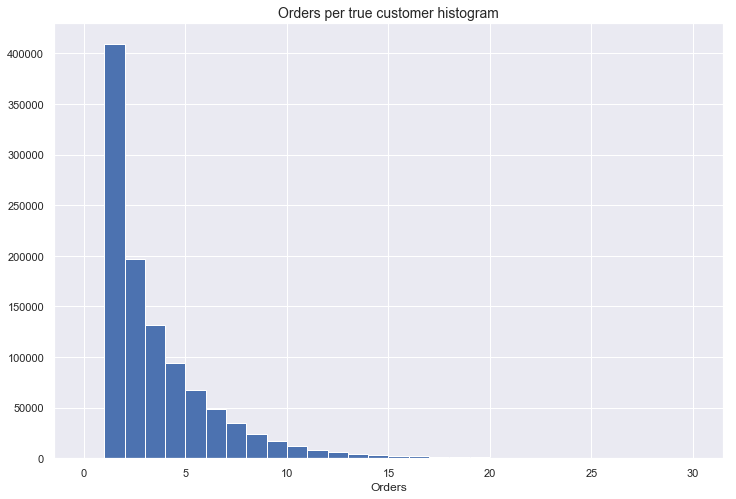

In [11]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(orders_per_customer, bins=30, range=(0, 30))
plt.xlabel('Orders')
plt.title('Orders per true customer histogram', fontsize=14)
plt.show()

In [12]:
Counter(orders_per_customer), np.percentile(orders_per_customer, 99.9)

(Counter({1: 409251,
          2: 196738,
          3: 131989,
          4: 94212,
          5: 67275,
          6: 48588,
          7: 35174,
          8: 24487,
          9: 17183,
          10: 11994,
          11: 8501,
          12: 6158,
          13: 4400,
          14: 3264,
          15: 2474,
          16: 1855,
          17: 1451,
          18: 1139,
          19: 890,
          20: 699,
          21: 563,
          22: 452,
          23: 330,
          24: 294,
          25: 260,
          26: 194,
          27: 181,
          28: 163,
          29: 117,
          30: 98,
          31: 90,
          32: 72,
          33: 69,
          34: 58,
          35: 53,
          36: 38,
          37: 28,
          38: 38,
          39: 35,
          40: 23,
          41: 29,
          42: 12,
          43: 17,
          44: 16,
          45: 22,
          46: 18,
          47: 17,
          48: 8,
          49: 14,
          50: 12,
          51: 7,
          52: 3,
          53: 3,

#### Timedeltas between orders

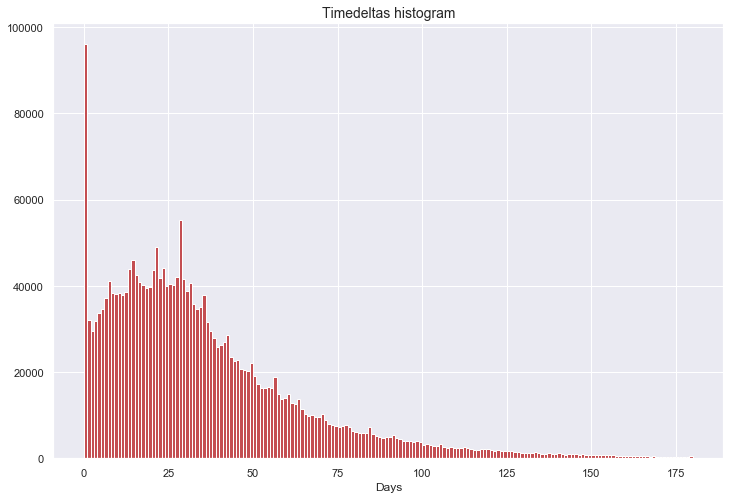

In [13]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(timedeltas_between_orders, bins=180, range=(0, 180), color='r')
plt.xlabel('Days')
plt.title('Timedeltas histogram', fontsize=14)
plt.show()

In [14]:
np.percentile(timedeltas_between_orders, 10)

5.0

#### Delivery zipcodes per true customer

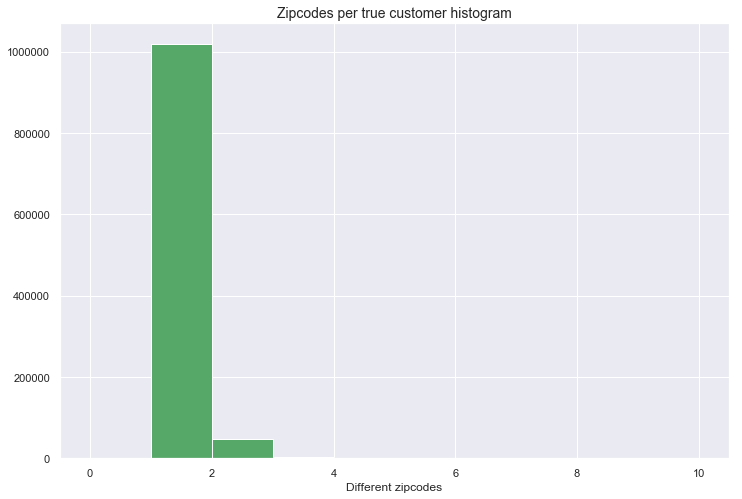

In [15]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(set_zipcodes_per_customer, bins=10, range=(0, 10), color='g')
plt.xlabel('Different zipcodes')
plt.title('Zipcodes per true customer histogram', fontsize=14)
plt.show()

In [16]:
Counter(set_zipcodes_per_customer), np.percentile(set_zipcodes_per_customer, 99.9)

(Counter({1: 1018515,
          2: 48089,
          3: 3717,
          4: 518,
          5: 122,
          6: 53,
          7: 43,
          8: 31,
          9: 15,
          10: 18,
          11: 4,
          12: 5,
          13: 4,
          14: 2,
          15: 4,
          16: 5,
          17: 2,
          18: 2,
          19: 1,
          20: 1,
          22: 1,
          24: 2,
          25: 2,
          29: 1,
          30: 1,
          31: 1,
          39: 1,
          40: 1,
          65: 2,
          68: 1,
          71: 1,
          112: 1,
          118: 2,
          138: 1,
          199: 1,
          207: 1,
          302: 1,
          348: 1,
          607: 1,
          815: 1,
          820: 1,
          7596: 1}),
 3.0)

#### Basket Values

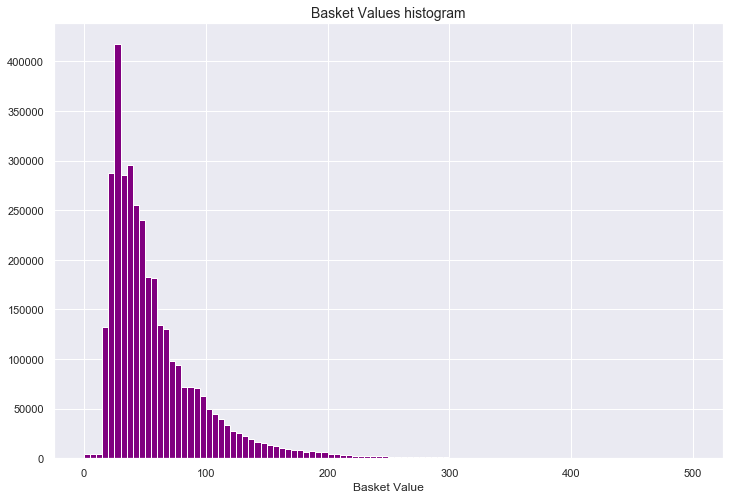

In [17]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(basket_values, bins=100, range=(0, 500), color='purple')
plt.xlabel('Basket Value')
plt.title('Basket Values histogram', fontsize=14)
plt.show()

In [18]:
np.percentile(basket_values, 99.5)

283.44

#### Total sales value

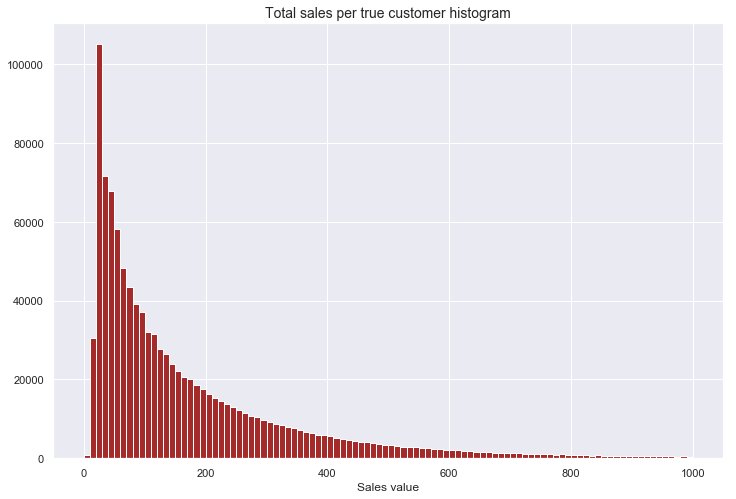

In [19]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(total_sales_values, bins=100, range=(0, 1000), color='brown')
plt.xlabel('Sales value')
plt.title('Total sales per true customer histogram', fontsize=14)
plt.show()

In [20]:
np.max(total_sales_values), np.percentile(total_sales_values, 99.9)

(967150.17, 2694.4572800000387)

#### Items per order

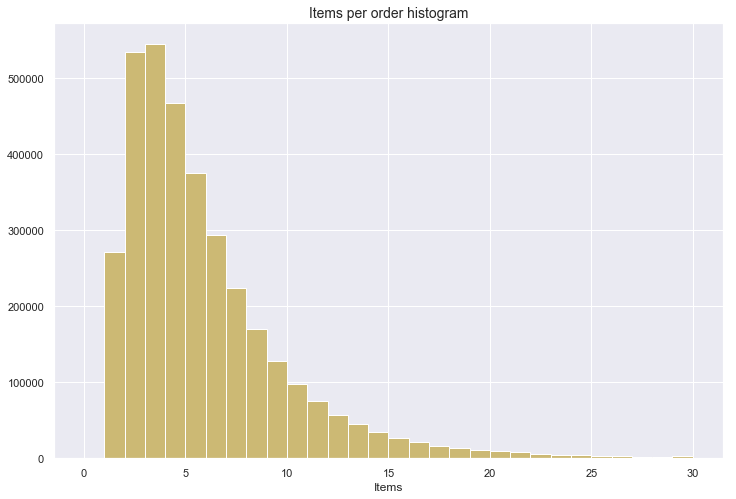

In [21]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(items_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Items')
plt.title('Items per order histogram', fontsize=14)
plt.show()

In [22]:
Counter(items_per_order), np.percentile(items_per_order, 99.9)

(Counter({1: 271573,
          2: 534790,
          3: 545152,
          4: 468138,
          5: 375939,
          6: 294532,
          7: 224438,
          8: 169662,
          9: 127820,
          10: 97948,
          11: 74894,
          12: 57631,
          13: 44722,
          14: 34378,
          15: 26822,
          16: 21528,
          17: 16847,
          18: 13387,
          19: 10688,
          20: 9310,
          21: 8026,
          22: 6023,
          23: 4959,
          24: 4091,
          25: 3260,
          26: 2734,
          27: 2362,
          28: 1922,
          29: 1565,
          30: 1423,
          31: 1252,
          32: 1065,
          33: 882,
          34: 707,
          35: 667,
          36: 510,
          37: 522,
          38: 426,
          39: 350,
          40: 353,
          41: 337,
          42: 290,
          43: 246,
          44: 186,
          45: 198,
          46: 166,
          47: 152,
          48: 128,
          49: 108,
          50: 130,

#### Order positions per order

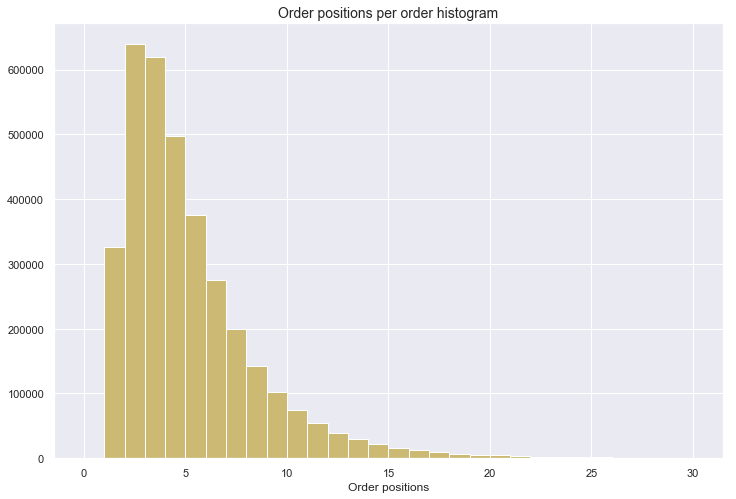

In [23]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(order_positions_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Order positions')
plt.title('Order positions per order histogram', fontsize=14)
plt.show()

In [24]:
Counter(order_positions_per_order), np.percentile(order_positions_per_order, 99.9)

(Counter({1: 325336,
          2: 639297,
          3: 619187,
          4: 496936,
          5: 375292,
          6: 275896,
          7: 199707,
          8: 142856,
          9: 102198,
          10: 73896,
          11: 53771,
          12: 39534,
          13: 29145,
          14: 21726,
          15: 16008,
          16: 12419,
          17: 9191,
          18: 7125,
          19: 5591,
          20: 4324,
          21: 3420,
          22: 2634,
          23: 2027,
          24: 1655,
          25: 1301,
          26: 1002,
          27: 879,
          28: 694,
          29: 541,
          30: 459,
          31: 377,
          32: 350,
          33: 263,
          34: 216,
          35: 173,
          36: 153,
          37: 118,
          38: 114,
          39: 84,
          40: 76,
          41: 72,
          42: 66,
          43: 47,
          44: 43,
          45: 35,
          46: 32,
          47: 26,
          48: 25,
          49: 23,
          50: 24,
          51: 16,
  

#### Different animals - Lead PG2- per true customer

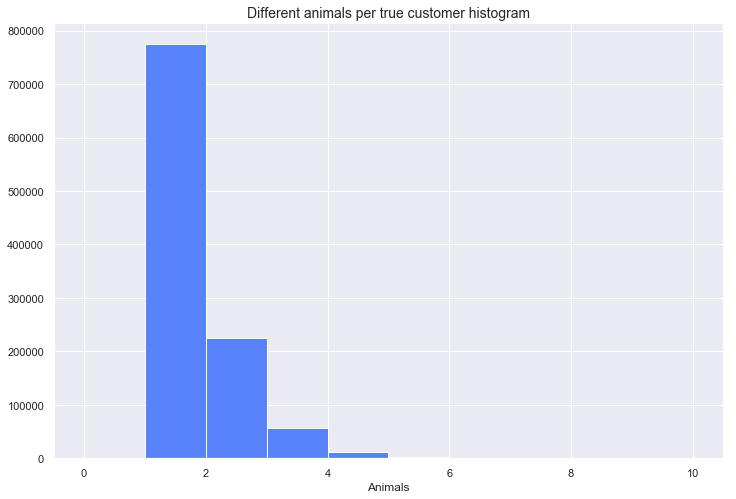

In [25]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(animals_per_customer, bins=10, range=(0, 10), color='#5882FA')
plt.xlabel('Animals')
plt.title('Different animals per true customer histogram', fontsize=14)
plt.show()

In [26]:
np.max(animals_per_customer), np.percentile(animals_per_customer, 99)

(10, 4.0)

In [27]:
Counter(animals_per_customer)

Counter({1: 774785,
         2: 225489,
         3: 56589,
         4: 11815,
         5: 2107,
         6: 330,
         7: 48,
         8: 9,
         9: 4,
         10: 1})

#### Different Lead PG3 per true customer

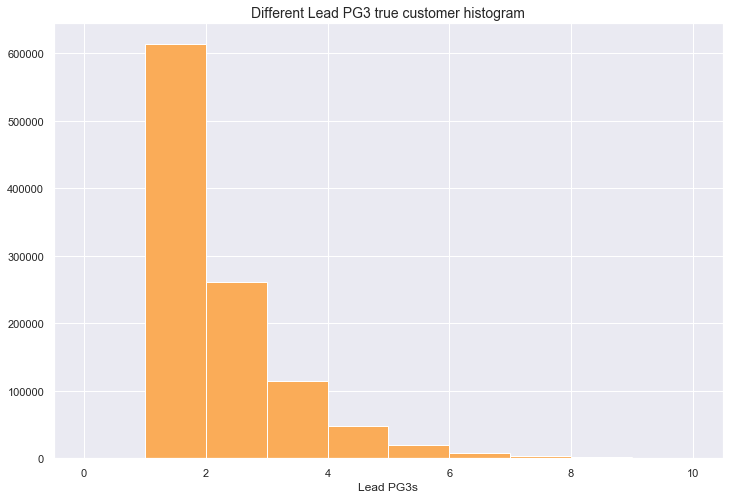

In [28]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(lead_prod_groups_3_per_customer, bins=10, range=(0, 10), color='#FAAC58')
plt.xlabel('Lead PG3s')
plt.title('Different Lead PG3 true customer histogram', fontsize=14)
plt.show()

In [29]:
np.max(lead_prod_groups_3_per_customer), np.percentile(lead_prod_groups_3_per_customer, 99.9)

(38, 9.0)

In [30]:
Counter(lead_prod_groups_3_per_customer)

Counter({1: 613866,
         2: 261070,
         3: 113894,
         4: 47553,
         5: 19801,
         6: 8249,
         7: 3702,
         8: 1595,
         9: 727,
         10: 345,
         11: 180,
         12: 76,
         13: 52,
         14: 21,
         15: 14,
         16: 6,
         17: 6,
         18: 4,
         19: 3,
         20: 1,
         21: 1,
         22: 3,
         23: 2,
         24: 1,
         26: 1,
         35: 1,
         37: 1,
         38: 2})

#### Brands -Lead PG4- per true customer

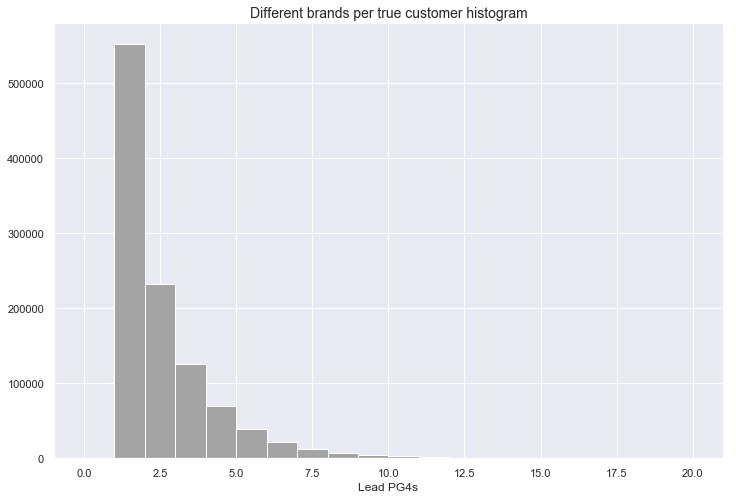

In [31]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(brands_per_customer, bins=20, range=(0, 20), color='#A4A4A4')
plt.xlabel('Lead PG4s')
plt.title('Different brands per true customer histogram', fontsize=14)
plt.show()

In [32]:
np.max(brands_per_customer), np.percentile(brands_per_customer, 99.9)

(202, 15.0)

In [33]:
Counter(brands_per_customer)

Counter({1: 552073,
         2: 232398,
         3: 125311,
         4: 69170,
         5: 38923,
         6: 21708,
         7: 12411,
         8: 7300,
         9: 4302,
         10: 2599,
         11: 1638,
         12: 1041,
         13: 708,
         14: 464,
         15: 289,
         16: 218,
         17: 145,
         18: 108,
         19: 80,
         20: 57,
         21: 53,
         22: 29,
         23: 30,
         24: 20,
         25: 13,
         26: 17,
         27: 10,
         28: 7,
         29: 4,
         30: 6,
         31: 4,
         32: 5,
         33: 2,
         34: 3,
         35: 1,
         36: 2,
         37: 2,
         38: 2,
         41: 1,
         42: 1,
         43: 1,
         44: 1,
         46: 3,
         50: 3,
         54: 1,
         58: 1,
         61: 1,
         63: 1,
         65: 1,
         66: 1,
         71: 1,
         75: 1,
         76: 1,
         78: 1,
         108: 1,
         127: 1,
         160: 1,
         202: 1})

#### Different lead shop articles per customer

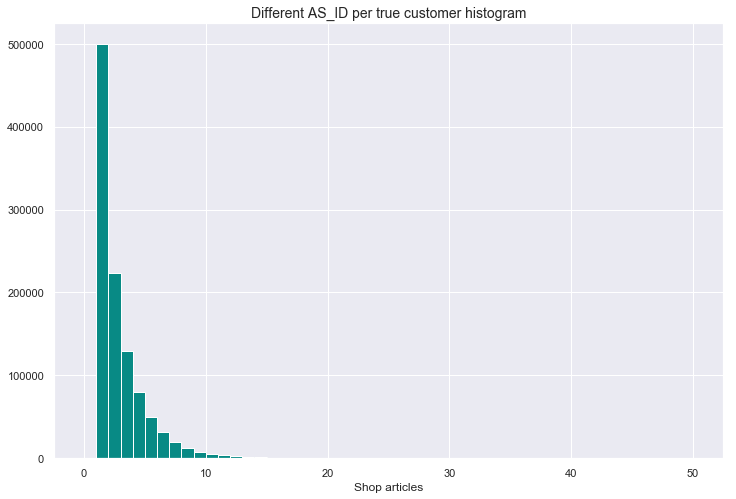

In [34]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_per_customer, bins=50, range=(0, 50), color='#088A85')
plt.xlabel('Shop articles')
plt.title('Different AS_ID per true customer histogram', fontsize=14)
plt.show()

In [35]:
Counter(arts_shop_per_customer), np.percentile(arts_shop_per_customer, 99.9)

(Counter({1: 499581,
          2: 223550,
          3: 129473,
          4: 79650,
          5: 49918,
          6: 31293,
          7: 19581,
          8: 12572,
          9: 7940,
          10: 5280,
          11: 3456,
          12: 2400,
          13: 1720,
          14: 1124,
          15: 881,
          16: 602,
          17: 453,
          18: 341,
          19: 290,
          20: 193,
          21: 137,
          22: 109,
          23: 97,
          24: 94,
          25: 69,
          26: 40,
          27: 41,
          28: 44,
          29: 30,
          30: 21,
          31: 24,
          32: 18,
          33: 13,
          34: 13,
          35: 8,
          36: 11,
          37: 8,
          38: 6,
          39: 6,
          40: 2,
          41: 6,
          42: 7,
          43: 2,
          44: 10,
          45: 5,
          46: 4,
          47: 7,
          48: 1,
          49: 2,
          50: 2,
          52: 2,
          53: 1,
          54: 3,
          55: 3,
        

#### Ratio Different Lead AS_ID / Orders 

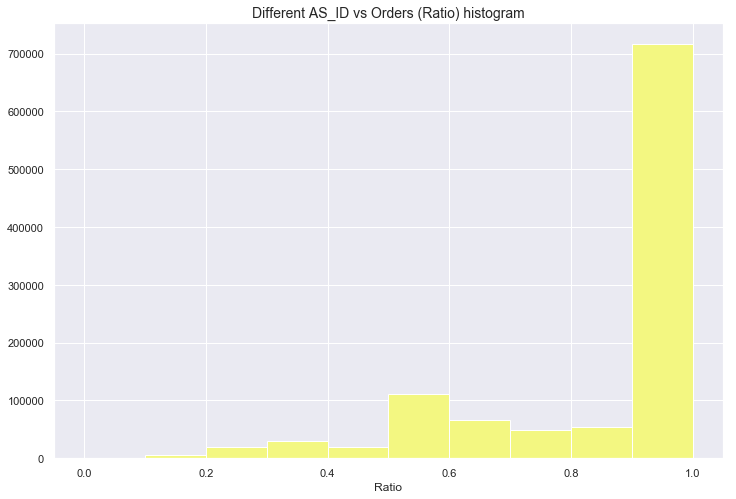

In [36]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_orders_ratio_per_customer, bins=10, range=(0, 1), color='#F3F781')
plt.xlabel('Ratio')
plt.title('Different AS_ID vs Orders (Ratio) histogram', fontsize=14)
plt.show()

In [37]:
Counter(arts_shop_orders_ratio_per_customer), np.percentile(arts_shop_orders_ratio_per_customer, 99)

(Counter({0.036: 2,
          0.038: 1,
          0.05: 3,
          0.052: 1,
          0.053: 2,
          0.056: 4,
          0.059: 5,
          0.062: 8,
          0.067: 11,
          0.069: 1,
          0.071: 13,
          0.074: 1,
          0.077: 23,
          0.083: 38,
          0.091: 73,
          0.095: 4,
          0.097: 1,
          0.1: 140,
          0.103: 1,
          0.105: 5,
          0.111: 314,
          0.114: 1,
          0.118: 5,
          0.12: 1,
          0.125: 620,
          0.13: 5,
          0.133: 26,
          0.136: 2,
          0.138: 3,
          0.143: 1198,
          0.148: 1,
          0.15: 4,
          0.154: 63,
          0.158: 8,
          0.16: 3,
          0.161: 1,
          0.167: 2280,
          0.171: 1,
          0.172: 2,
          0.174: 2,
          0.176: 23,
          0.179: 1,
          0.182: 233,
          0.183: 1,
          0.185: 3,
          0.188: 37,
          0.19: 10,
          0.194: 2,
          0.2: 4896,
   

#### Max order counter per customer

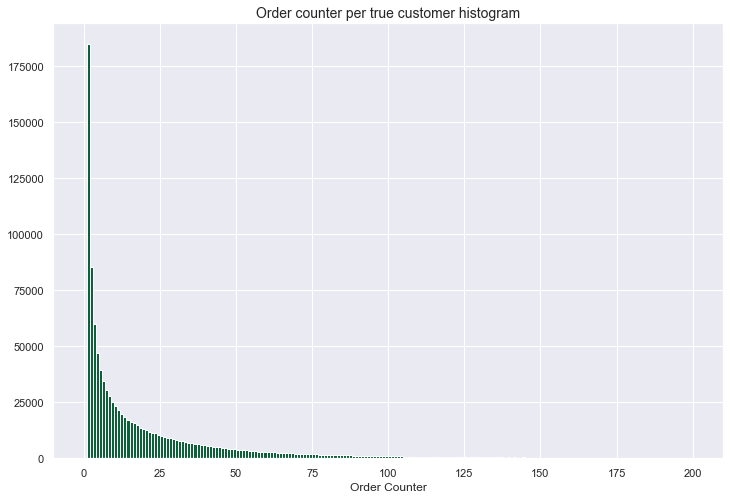

In [110]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(max_order_counter_per_customer, bins=200, range=(0, 200), color='#0B6138')
plt.xlabel('Order Counter')
plt.title('Order counter per true customer histogram', fontsize=14)
plt.show()

In [39]:
Counter(max_order_counter_per_customer).most_common(), np.percentile(max_order_counter_per_customer, 99.9)

([(1, 184903),
  (2, 85184),
  (3, 59799),
  (4, 47061),
  (5, 39350),
  (6, 34617),
  (7, 30659),
  (8, 27625),
  (9, 25348),
  (10, 23208),
  (11, 21455),
  (12, 19814),
  (13, 18591),
  (14, 17287),
  (15, 16414),
  (16, 15728),
  (17, 14673),
  (18, 13635),
  (19, 13290),
  (20, 12525),
  (21, 11907),
  (22, 11422),
  (23, 11079),
  (24, 10505),
  (25, 9995),
  (26, 9686),
  (27, 9110),
  (28, 8901),
  (29, 8586),
  (30, 8092),
  (31, 7746),
  (32, 7571),
  (33, 7324),
  (35, 6851),
  (34, 6828),
  (36, 6403),
  (37, 6186),
  (38, 5844),
  (39, 5779),
  (40, 5476),
  (41, 5446),
  (42, 5162),
  (43, 4969),
  (44, 4864),
  (45, 4630),
  (46, 4545),
  (47, 4342),
  (48, 4053),
  (49, 3959),
  (51, 3891),
  (50, 3856),
  (53, 3645),
  (52, 3593),
  (54, 3434),
  (55, 3354),
  (56, 3155),
  (58, 3005),
  (57, 2997),
  (59, 2985),
  (60, 2780),
  (61, 2744),
  (62, 2660),
  (64, 2498),
  (63, 2483),
  (65, 2424),
  (66, 2390),
  (67, 2267),
  (68, 2174),
  (70, 2124),
  (69, 2062),
  (7

### Outlier detection based on percentiles

In [40]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum',
       'O_GWERT_list', 'DATE_N_SV_list', 'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID',
       'L4_PG_ID', 'OCI_PLZ_list', 'O_TIMEDELTAS'],
      dtype='object')

We define here the percentiles of each feature for testing just within our data...

In [41]:
features_percentiles = [np.percentile(orders_per_customer, 99.95), np.percentile(timedeltas_between_orders, 5), 
                                np.percentile(set_zipcodes_per_customer, 99.95), np.percentile(total_sales_values, 99.95), 
                                np.percentile(basket_values, 99.95), np.percentile(items_per_order, 99.95),
                                np.percentile(order_positions_per_order, 99.95),
                                np.percentile(arts_shop_per_customer, 99.95), 
                        np.rint(np.percentile(max_order_counter_per_customer, 99.95))]

In [42]:
features_percentiles

[34.0,
 1.0,
 4.0,
 3420.776480000028,
 569.3528750000614,
 47.0,
 32.0,
 23.412000000011176,
 417.0]

In [43]:
features_percentiles = pd.DataFrame([features_percentiles], columns=['ORDERS', 
                                                                'TD_PER_ORDER', 'ZIPCODES', 'TOTAL_SALES', 
                                                                'BASKET_VALUE', 'ITEMS_PER_ORDER','O_POS_PER_ORDER',
                                                                'LEAD_AS_IDs', 'ORDER_COUNTER'])

In [44]:
features_percentiles

,ORDERS,TD_PER_ORDER,ZIPCODES,TOTAL_SALES,BASKET_VALUE,ITEMS_PER_ORDER,O_POS_PER_ORDER,LEAD_AS_IDs,ORDER_COUNTER
0,34.0,1.0,4.0,3420.77648,569.352875,47.0,32.0,23.412,417.0


In [45]:
features_percentiles['TD_PER_ORDER'].values[0]

1.0

We define using a binary classification (0, 1) if the customer or one of his orders is considered as outlier for each of the features tested...

In [46]:
# Variables to check per true customer: orders, different delivery zipcodes, total sales, different lead pg2/pg3/pg4

In [47]:
customers['OUTL_ORDERS'] = [(i > features_percentiles['ORDERS'].values[0]) * 1 for i in customers['O_ID_len'].values]

In [48]:
customers['OUTL_OCI_PLZ'] = [(len(i.keys()) > features_percentiles['ZIPCODES'].values[0]) * 1 for i in customers['OCI_PLZ_list'].values]

In [49]:
customers['OUTL_TOT_O_GWERT'] = [(i > features_percentiles['TOTAL_SALES'].values[0]) * 1 for i in customers['O_GWERT_sum'].values]

In [50]:
#customers['OUTL_PG2'] = [(len(i.keys()) > features_percentiles['PG2'].values[0]) * 1 for i in customers['L2_PG_ID'].values]

In [51]:
#customers['OUTL_PG3'] = [(len(i.keys()) > features_percentiles['PG3'].values[0]) * 1 for i in customers['L3_PG_ID'].values]

In [52]:
#customers['OUTL_PG4'] = [(len(i.keys()) > features_percentiles['PG4'].values[0]) * 1 for i in customers['L4_PG_ID'].values]

In [53]:
customers['OUTL_AS_IDs'] = [(len(i.keys()) > features_percentiles['LEAD_AS_IDs'].values[0]) * 1 for i in customers['LEAD_AS_ID'].values]

In [54]:
customers['OUTL_O_COUNTER'] = [(sum(i) > features_percentiles['ORDER_COUNTER'].values[0]) * 1 for i in customers['O_K_COUNTER_MAX_list'].values]

In [55]:
# Variables to check per order belonging to the customer: timedeltas between orders, basket values, items per order

In [56]:
# For this variable let's start with the percentile 5 (4 days timedelta) instead of percentile 2.5 (1 day)
customers['OUTL_TIMEDELTAS'] = [[(j < features_percentiles['TD_PER_ORDER'].values[0]) * 1 if len(i) >= 1 else i for j in i]
                                    for i in customers['O_TIMEDELTAS'].values]

In [57]:
customers['OUTL_BASKET_VALUES'] = [[(j > features_percentiles['BASKET_VALUE'].values[0]) * 1 for j in i]
                                for i in customers['O_GWERT_list'].values]

In [58]:
customers['OUTL_ITEMS'] = [[(sum(j) > features_percentiles['ITEMS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AMOUNT_list'].values]

In [59]:
customers['OUTL_O_POS'] = [[(j > features_percentiles['O_POS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AS_ID_len_list'].values]

In [60]:
# For last three variables let's compute the relevance of outliers within their all orders

In [61]:
customers['OUTL_TD_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_TIMEDELTAS'].values]

In [62]:
customers['OUTL_BV_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_BASKET_VALUES'].values]

In [63]:
customers['OUTL_ITEMS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_ITEMS'].values]

In [64]:
customers['OUTL_O_POS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_O_POS'].values]

In [65]:
customers['OCI_PLZ_len'] = customers['OCI_PLZ_list'].apply(len)

In [66]:
customers['LEAD_AS_ID_len'] = customers['LEAD_AS_ID'].apply(len)

In [67]:
customers['MAX_O_COUNTER'] = customers['O_K_COUNTER_MAX_list'].apply(sum)

In [68]:
customers['DIFF_ZIP_PERC'] = np.round(customers['OCI_PLZ_len'] / customers['O_ID_len'], 3)

### Identify blacklist profiles using outlier detection


+ Dropshippers
+ High basket value customers
+ High frequency customers

**Dropshippers**: 

Several delivery zipcodes and must match also one of the hard criteria: being an outlier in terms of amount of orders, total sales value or order counter

In [69]:
dropshippers = list(customers[(customers['OUTL_OCI_PLZ'] == 1) & ((customers['OUTL_ORDERS'] == 1) |
                                              (customers['OUTL_TOT_O_GWERT'] == 1) |
                                              (customers['OUTL_O_COUNTER'] == 1)
                                             ) & (customers['DIFF_ZIP_PERC'] >= 0.3)]['TC_ID'].values)

In [70]:
len(dropshippers)

41

In [71]:
customers[customers['TC_ID'].isin(dropshippers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
208,1192,222,"[2018-05-03 11:33:36, 2018-05-04 15:01:08, 201...","[18122635, 19318218, 20376253]","[3952, 3955, 3965, 3975, 3977, 3978, 3979, 405...","[4054, 91, 204]",10750.00,"[77.59, 19.39, 48.49, 29.38, 96.99, 126.09, 12...","[(2018-05-03 11:33:36, 77.59), (2018-05-04 15:...","[[42715, 63085], [42715, 64786], [50111, 42715...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.507,0.000,0.000,0.000,207,90,4349,0.932
486,2879,80,"[2018-05-03 08:56:26, 2018-05-09 12:11:37, 201...","[49367, 392864, 431231, 20517045, 22031357]","[398, 399, 400, 401, 402, 403, 404, 405, 406, ...","[456, 14, 265, 8, 1]",9806.10,"[464.02, 109.73, 113.05, 92.59, 114.27, 102.45...","[(2018-05-03 08:56:26, 464.02), (2018-05-09 12...","[[57449, 72929, 68059, 62525, 20124, 5482, 708...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.228,0.000,0.000,0.000,24,64,744,0.300
1142,6254,889,"[2018-05-01 19:39:07, 2018-05-02 12:01:06, 201...","[12014978, 21536202]","[507, 508, 509, 510, 511, 512, 513, 514, 515, ...","[1333, 70]",27314.32,"[27.61, 28.53, 18.4, 30.37, 17.71, 18.4, 27.61...","[(2018-05-01 19:39:07, 27.61), (2018-05-02 12:...","[[26641, 42715, 8984], [47047, 8984, 42715], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.779,0.000,0.000,0.000,607,163,1403,0.683
1509,8221,37,"[2018-05-02 08:35:45, 2018-05-09 10:26:58, 201...",[10404550],"[175, 176, 177, 178, 179, 180, 181, 182, 183, ...",[211],1709.51,"[21.31, 32.86, 18.39, 30.92, 56.16, 110.39, 54...","[(2018-05-02 08:35:45, 21.31), (2018-05-09 10:...","[[67836, 42715, 67861, 60602], [32619, 75021, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.167,0.000,0.000,0.000,15,24,211,0.405
1522,8281,115,"[2018-05-02 20:31:59, 2018-05-03 21:36:26, 201...",[15902877],"[406, 408, 409, 411, 413, 414, 415, 416, 417, ...",[537],5655.64,"[43.69, 52.73, 43.69, 42.74, 42.74, 29.44, 71....","[(2018-05-02 20:31:59, 43.69), (2018-05-03 21:...","[[37968, 42715], [42715, 6168, 38833], [37968,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.237,0.000,0.000,0.000,112,15,537,0.974
2974,15661,12,"[2018-05-11 13:41:33, 2018-06-22 19:15:19, 201...","[170686, 1358174, 10282206, 21053410]","[98, 99, 100, 52, 53, 4777, 4788, 4911, 5187, ...","[100, 53, 5311, 2]",924.28,"[213.12, 23.86, 22.97, 49.49, 20.46, 129.98, 8...","[(2018-05-11 13:41:33, 49.49), (2018-06-22 19:...","[[74227, 64620, 6168, 50811, 75323, 61244, 804...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.091,0.000,0.000,0.000,9,10,5466,0.750
3609,18767,39,"[2018-05-08 17:25:30, 2018-05-21 15:29:55, 201...",[10141442],"[184, 185, 186, 187, 188, 189, 190, 191, 192, ...",[223],6056.65,"[395.99, 120.17, 180.75, 104.8, 168.79, 145.62...","[(2018-05-08 17:25:30, 395.99), (2018-05-21 15...","[[26383, 2502, 24371, 6168, 6169, 76343, 62299...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.079,0.000,0.000,0.000,16,25,223,0.410
7552,37875,31,"[2018-05-01 12:47:27, 2018-05-01 20:18:45, 201...",[14790718],"[558, 559, 560, 561, 562, 563, 564, 565, 566, ...",[588],1806.30,"[54.99, 39.99, 35.99, 49.99, 39.99, 54.99, 66....","[(2018-05-01 12:47:27, 54.99), (2018-05-01 20:...","[[70996], [79024], [57804], [64699], [79024], ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.600,0.000,0.000,0.000,29,20,588,0.935
8920,45836,59,"[2018-05-02 22:14:

In [72]:
#Dropshippers early detection using other features: different lead as_id or outlier TD%
customers[(customers['OUTL_OCI_PLZ'] == 1) & (~customers['TC_ID'].isin(dropshippers)) &
          (customers['DIFF_ZIP_PERC'] >= 0.3) & (customers['OUTL_TD_%'] >= 0.5)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
345849,4287513,8,"[2018-11-21 17:26:29, 2018-11-21 17:48:36, 201...",[21946033],"[1, 2, 3, 4, 6, 7, 8, 9]",[9],346.76,"[45.13, 54.3, 45.57, 35.88, 18.47, 82.44, 29.0...","[(2018-11-21 17:26:29, 45.13), (2018-11-21 17:...","[[6169, 42225, 61151, 42715], [61339, 42715], ...",...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.571,0.0,0.0,0.0,8,7,9,1.000
722479,12544265,7,"[2018-06-25 15:36:07, 2018-09-17 22:43:08, 201...",[17012058],"[4, 5, 6, 7, 8, 9, 10]",[10],195.67,"[38.99, 26.98, 26.98, 26.98, 26.78, 25.98, 22.98]","[(2018-06-25 15:36:07, 38.99), (2018-09-17 22:...","[[70462], [20886, 6169, 70927, 64434], [64434,...",...,"[0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",0.667,0.0,0.0,0.0,5,3,10,0.714


**High basket value customers**

Customers labeled as outliers by their total sales value but not because of the orders and of course not included in the previous group (now the outlier value in delivery zipcodes is forced to be 0)

In [73]:
high_basket_customers = list(customers[(customers['OUTL_TOT_O_GWERT'] == 1) & (customers['OUTL_ORDERS'] == 0) &
         (~customers['TC_ID'].isin(dropshippers))]['TC_ID'].values)

In [74]:
len(high_basket_customers)

355

In [75]:
customers[customers['TC_ID'].isin(high_basket_customers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
545,3198,19,"[2018-05-13 22:08:19, 2018-06-04 00:02:55, 201...",[705060],"[141, 142, 143, 144, 145, 146, 147, 148, 149, ...",[159],4476.77,"[197.92, 181.73, 217.72, 246.52, 248.32, 280.7...","[(2018-05-13 22:08:19, 197.92), (2018-06-04 00...","[[5482, 62001, 2502, 65091, 72957], [65091, 25...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.056,0.000,0.000,0.000,1,3,159,0.053
566,3323,15,"[2018-05-01 15:10:12, 2018-05-31 10:58:17, 201...",[3173651],"[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",[91],4064.07,"[372.37, 280.62, 146.64, 350.94, 395.93, 761.2...","[(2018-05-01 15:10:12, 372.37), (2018-05-31 10...","[[5482, 78323, 63217, 8984], [8984, 63217, 548...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.071,0.133,0.000,0.000,1,11,91,0.067
580,3388,26,"[2018-05-14 21:25:52, 2018-05-16 20:40:48, 201...",[4583580],"[186, 187, 188, 189, 190, 191, 192, 193, 194, ...",[211],6030.93,"[239.04, 684.38, 77.29, 218.21, 320.54, 494.59...","[(2018-05-14 21:25:52, 239.04), (2018-05-16 20...","[[32621, 69837, 6169, 72330, 63210, 32619, 551...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.040,0.038,0.000,0.000,5,16,211,0.192
629,3601,29,"[2018-05-20 07:18:28, 2018-05-24 08:24:20, 201...",[14889656],"[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 6...",[78],4636.13,"[286.5, 284.95, 215.59, 101.18, 223.95, 149.84...","[(2018-05-20 07:18:28, 286.5), (2018-05-24 08:...","[[4029, 5482, 7883, 7992, 10143, 27322, 27908,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.036,0.000,0.000,0.000,8,24,78,0.276
898,4932,25,"[2018-05-09 09:58:13, 2018-05-18 17:04:25, 201...",[12559398],"[122, 123, 124, 125, 126, 127, 128, 129, 130, ...",[146],4249.11,"[93.74, 340.01, 179.98, 219.16, 103.82, 354.66...","[(2018-05-09 09:58:13, 93.74), (2018-05-18 17:...","[[69101, 28114, 62610, 79816, 5482, 70906, 655...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.083,0.000,0.000,0.040,2,19,146,0.080
948,5210,26,"[2018-05-03 09:38:57, 2018-05-16 22:54:09, 201...",[6311690],"[224, 225, 226, 227, 228, 229, 230, 231, 232, ...",[249],6228.16,"[174.91, 427.83, 117.04, 174.91, 158.0, 441.64...","[(2018-05-03 09:38:57, 174.91), (2018-05-16 22...","[[65186, 8984, 42715], [42715, 64016, 24751, 2...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0.040,0.000,0.000,0.038,1,15,249,0.038
1119,6115,14,"[2018-05-07 11:59:08, 2018-05-19 16:19:26, 201...",[13576597],"[58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 6...",[71],5653.16,"[370.21, 532.11, 515.44, 451.28, 270.72, 257.7...","[(2018-05-07 11:59:08, 370.21), (2018-05-19 16...","[[75306, 61279, 61214, 61155, 61293, 77918, 61...",...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000,0.143,0.214,0.000,2,12,71,0.143
1157,6323,19,"[2018-05-02 00:59:36, 2018-05-18 15:58:45, 201...",[5340263],"[135, 136, 138, 139, 140, 141, 142, 143, 144, ...",[154],4426.21,"[398.3, 196.97, 299.59, 298.28, 185.37, 311.18...","[(2018-05-02 00:59:36, 398.3), (2018-05-18 15:...","[[71062, 75528, 5482, 50339, 76801, 68279, 626...",...,"[1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.056,0.000,0.263,0.000,2,13,154,0.105
1166,6360,19,"[2018-05-08 12:35:24, 2018-05-29 07:42:38, 201...",[18356719],"[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20...",[27],6064.60,"[118.42, 187.72, 194.05, 196.99, 197.79, 201.8...","[(2018-05-08 12:35:24,

In [76]:
# Early detection of high basket value customers using other features: different lead as_id or outlier TD%
customers[(~customers['TC_ID'].isin(dropshippers)) & (~customers['TC_ID'].isin(high_basket_customers)) &
          (customers['OUTL_BV_%'] >= 0.5) & (customers['O_ID_len'] >= 3)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
5785,28995,43,"[2018-05-06 21:04:06, 2018-05-08 22:25:08, 201...",[8899155],"[195, 196, 197, 198, 199, 200, 201, 202, 203, ...",[237],29220.61,"[873.57, 461.69, 545.72, 744.43, 1071.77, 317....","[(2018-05-06 21:04:06, 873.57), (2018-05-08 22...","[[2198, 76474, 77542, 67222, 4029, 76472, 7064...",...,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",0.286,0.512,0.209,0.163,4,30,237,0.093
6096,30486,5,"[2018-05-08 18:01:57, 2018-05-23 10:11:36, 201...","[20164580, 20738110, 21107849, 21343505]","[1, 2, 1, 1, 1]","[2, 1, 1, 1]",3251.16,"[595.77, 156.55, 1053.97, 852.76, 592.11]","[(2018-05-08 18:01:57, 595.77), (2018-05-23 10...","[[61086, 57449, 52631, 61279, 6169, 65427, 752...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.000,0.800,0.000,0.000,1,3,5,0.200
29241,146544,35,"[2018-05-02 12:31:53, 2018-05-07 15:36:05, 201...",[13549668],"[88, 89, 90, 92, 95, 96, 97, 98, 99, 100, 101,...",[125],30241.77,"[1292.63, 1452.68, 1428.64, 210.92, 211.45, 19...","[(2018-05-02 12:31:53, 1292.63), (2018-05-07 1...","[[61142, 61217, 61090, 61151, 61059, 61245, 61...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.176,0.629,0.143,0.029,1,19,125,0.029
41524,203189,3,"[2018-05-09 12:11:45, 2018-07-19 08:56:41, 201...",[16831381],"[7, 8, 9]",[9],2430.54,"[666.72, 783.92, 979.9]","[(2018-05-09 12:11:45, 666.72), (2018-07-19 08...","[[64702, 42715, 64661, 6169, 8984], [64661, 61...",...,"[0, 0, 0]","[0, 0, 0]",0.000,1.000,0.000,0.000,1,1,9,0.333
67385,324267,3,"[2018-06-02 11:38:18, 2018-06-06 09:10:41, 201...",[1095466],"[50, 51, 52]",[52],1256.03,"[601.83, 39.99, 614.21]","[(2018-06-02 11:38:18, 601.83), (2018-06-06 09...","[[73847, 61228, 25350, 42840, 3140, 42836, 428...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,52,0.333
74082,355709,3,"[2018-05-03 08:37:32, 2018-08-17 22:40:42, 201...",[7177521],"[27, 28, 29]",[29],1914.62,"[620.4, 626.86, 667.36]","[(2018-05-03 08:37:32, 620.4), (2018-08-17 22:...","[[52535, 63088, 55166, 6168, 76039, 5482, 4415...",...,"[0, 0, 0]","[0, 0, 0]",0.000,1.000,0.000,0.000,1,1,29,0.333
96219,463164,4,"[2018-05-22 21:30:14, 2018-08-06 21:56:41, 201...",[8992225],"[53, 55, 56, 57]",[57],2254.68,"[323.49, 436.17, 823.7, 671.32]","[(2018-05-22 21:30:14, 323.49), (2018-08-06 21...","[[74677, 75237, 52404, 64677, 17543, 52937, 63...",...,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.000,0.500,0.000,0.000,1,3,57,0.250
97708,471891,5,"[2018-06-19 10:47:00, 2018-07-08 23:19:39, 201...",[108348],"[235, 236, 237, 238, 239]",[239],1885.29,"[586.51, 45.98, 585.67, 594.15, 72.98]","[(2018-06-19 10:47:00, 586.51), (2018-07-08 23...","[[52343, 62817, 50811, 51331, 70700, 73639, 52...",...,"[0, 0, 0, 1, 0]","[0, 0, 0, 1, 0]",0.000,0.600,0.200,0.200,1,5,239,0.200
129281,779339,3,"[2018-06-19 14:51:49, 2018-07-12 14:01:42, 201...",[507970],"[37, 38, 39]",[39],1897.79,"[623.01, 1182.74, 92.04]","[(2018-06-19 14:51:49, 623.01), (2018-07-12 14...","[[70023, 42715], [63121, 42715, 63214], [42715...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,39,0.333
160885,1091161,4,"[2018-05-29 10:07:22, 2018-06-20 12:13:36, 201...",[925578],"[182, 183, 184, 185]",[185],2866.03,"[1373.13, 4.49, 233.59, 1254.82]","[(2018-05-29 10:07:22, 1373.13), (2018-06-20 1...","[[33695, 50811, 73647, 75092, 66860, 75207, 58...",...,"[1, 0, 0, 1]","[0, 0, 0, 0]",0.000,0.500,0.500,0.000,1,4,185,0.250


**High frequency/activity customers**

Customers not belonging to the dropshippers group having been labeled as outliers because of their orders (amount) and also requesting the outlier label in either, total sales value or max_order_counter

In [77]:
high_activity_customers = list(customers[(customers['OUTL_ORDERS'] == 1) & (~customers['TC_ID'].isin(dropshippers)) &
          ((customers['OUTL_TOT_O_GWERT'] == 1) |
         (customers['OUTL_O_COUNTER'] == 1))]['TC_ID'].values)

In [78]:
len(high_activity_customers)

232

In [79]:
customers[customers['TC_ID'].isin(high_activity_customers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
24,126,82,"[2018-05-01 15:57:52, 2018-05-06 00:18:31, 201...",[5658303],"[243, 244, 245, 246, 247, 248, 249, 250, 251, ...",[324],6499.20,"[115.11, 92.61, 108.05, 98.91, 70.86, 106.92, ...","[(2018-05-01 15:57:52, 115.11), (2018-05-06 00...","[[73457, 34269, 65447, 17097, 5482, 78905, 676...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.358,0.000,0.000,0.000,12,67,324,0.146
32,161,39,"[2018-05-04 09:51:38, 2018-05-08 09:07:39, 201...","[2430672, 3221148, 14104719]","[122, 123, 124, 125, 126, 127, 128, 129, 130, ...","[132, 155, 97]",12523.72,"[63.15, 45.56, 66.0, 28.01, 102.8, 80.7, 73.14...","[(2018-05-04 09:51:38, 63.15), (2018-05-08 09:...","[[28050, 70319, 42715, 28047], [42715, 67724, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.158,0.205,0.000,0.000,4,23,384,0.103
325,1952,93,"[2018-05-02 11:33:39, 2018-05-03 13:12:41, 201...","[489573, 512406, 535829, 614536, 650946, 67209...","[170, 171, 172, 173, 174, 34, 35, 36, 37, 38, ...","[174, 41, 316, 34, 92, 61, 195, 227, 372, 28, ...",8794.66,"[54.97, 31.98, 59.97, 29.44, 39.99, 18.79, 68....","[(2018-05-02 11:33:39, 162.15), (2018-05-03 13...","[[56980, 57811, 38424, 50859], [73457], [79027...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.217,0.000,0.000,0.000,19,60,1747,0.204
685,3934,59,"[2018-05-07 21:42:29, 2018-05-14 22:10:38, 201...","[1076041, 4759184, 7106093, 9816630, 15626521,...","[141, 142, 143, 64, 66, 68, 69, 70, 71, 72, 73...","[143, 74, 184, 145, 29, 2, 1, 1]",21812.10,"[196.22, 206.97, 174.95, 308.18, 19.39, 89.3, ...","[(2018-05-07 21:42:29, 585.13), (2018-05-14 22...","[[77920, 36637, 52937, 67834, 6169, 36538, 616...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.121,0.322,0.000,0.000,5,28,579,0.085
706,4066,39,"[2018-05-02 18:36:23, 2018-05-04 11:16:22, 201...","[846488, 8128846]","[304, 305, 306, 307, 308, 309, 310, 311, 312, ...","[330, 108]",2851.96,"[98.14, 109.97, 97.19, 100.48, 111.47, 93.22, ...","[(2018-05-02 18:36:23, 98.14), (2018-05-04 11:...","[[69166, 38666, 37447, 6169, 42715, 29374, 324...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.053,0.000,0.000,0.000,3,34,438,0.077
917,5049,113,"[2018-05-02 10:05:22, 2018-05-03 06:53:22, 201...","[67950, 302814, 1021372, 1344294, 1599916, 282...","[459, 460, 461, 462, 463, 464, 465, 466, 467, ...","[474, 215, 48, 266, 132, 283, 95, 78, 20, 16, ...",6692.18,"[71.62, 52.2, 47.0, 25.8, 55.08, 38.65, 24.09,...","[(2018-05-02 10:05:22, 71.62), (2018-05-03 06:...","[[64829, 42225, 67233, 51194, 42715, 8984, 707...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.259,0.000,0.000,0.000,20,73,1809,0.177
1170,6374,79,"[2018-05-01 12:55:25, 2018-05-02 15:57:22, 201...",[6888871],"[505, 506, 507, 508, 509, 510, 511, 512, 513, ...",[583],3275.55,"[18.48, 18.4, 29.62, 33.13, 63.5, 24.36, 20.67...","[(2018-05-01 12:55:25, 18.48), (2018-05-02 15:...","[[35464, 38569, 42715, 8984, 35376], [42715, 4...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.090,0.000,0.000,0.000,1,43,583,0.013
1289,7024,174,"[2018-05-04 13:48:40, 2018-05-04 14:05:36, 201...","[6717972, 22036804]","[572, 573, 574, 575, 576, 577, 578, 579, 580, ...","[744, 1]",21481.86,"[106.53, 138.24, 116.01, 97.36, 96.68, 192.93,...","[(2018-05-04 13:48:40, 106.53), (2018-05-04 14...","[[61317, 61277, 59374, 8984, 42715, 61212, 616...",...,"[0, 0, 0, 0,

In [80]:
#Early detection using timedeltas...
customers[(customers['OUTL_ORDERS'] == 0) & (customers['OUTL_TD_%'] >= 0.5) & (customers['O_ID_len'] >= 5)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
112,660,11,"[2018-06-22 18:33:08, 2018-07-23 22:37:39, 201...",[17031486],"[3, 4, 5, 6, 7, 8, 10, 9, 11, 12, 13]",[13],780.73,"[124.43, 125.38, 70.27, 43.69, 43.69, 45.59, 4...","[(2018-06-22 18:33:08, 124.43), (2018-07-23 22...","[[42715, 61231, 61231], [67405, 61231, 42715],...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.600,0.0,0.0,0.0,1,3,13,0.091
397,2368,11,"[2018-05-24 20:36:17, 2018-06-08 11:28:37, 201...",[16918403],"[49, 50, 51, 52, 53, 54, 57, 55, 56, 58, 59]",[59],1859.67,"[280.8, 399.74, 101.89, 108.75, 108.75, 125.41...","[(2018-05-24 20:36:17, 280.8), (2018-06-08 11:...","[[42715, 61093, 23378, 14843, 80638, 61037], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.800,0.0,0.0,0.0,1,3,59,0.091
1208,6597,5,"[2018-06-29 15:43:10, 2018-08-22 15:58:47, 201...",[16963285],"[13, 14, 15, 16, 17]",[17],350.22,"[101.94, 187.05, 25.98, 23.5, 11.75]","[(2018-06-29 15:43:10, 101.94), (2018-08-22 15...","[[29320, 68965, 6169, 26383, 68966, 20886], [6...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.0,0.0,0.0,1,3,17,0.200
1377,7570,5,"[2018-06-18 16:36:27, 2018-06-18 16:39:00, 201...",[5023683],"[25, 26, 27, 28, 29]",[29],1212.01,"[437.77, 116.98, 95.89, 236.74, 324.63]","[(2018-06-18 16:36:27, 437.77), (2018-06-18 16...","[[77474, 56512, 55878, 73026, 75530, 52417, 70...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.0,0.0,0.0,1,3,29,0.200
1582,8599,5,"[2018-05-04 11:17:37, 2018-05-04 16:53:05, 201...",[3704452],"[54, 55, 56, 57, 58]",[58],470.82,"[16.75, 27.91, 175.62, 136.19, 114.35]","[(2018-05-04 11:17:37, 16.75), (2018-05-04 16:...","[[6169, 42715, 66314], [71785, 42715, 6169, 64...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.0,0.0,0.0,2,5,58,0.400
2035,10993,5,"[2018-05-09 21:20:56, 2018-08-18 11:34:05, 201...",[7037581],"[53, 54, 55, 56, 57]",[57],389.56,"[98.93, 108.73, 46.97, 46.97, 87.96]","[(2018-05-09 21:20:56, 98.93), (2018-08-18 11:...","[[28741, 6169, 71060, 27624], [67426, 65244, 6...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.0,0.0,0.0,1,3,57,0.200
3860,19956,18,"[2018-05-07 16:55:55, 2018-05-07 16:59:39, 201...","[3132770, 12509212]","[98, 99, 100, 101, 102, 103, 104, 105, 106, 10...","[107, 52]",901.38,"[31.01, 49.34, 51.23, 57.88, 54.09, 55.97, 59....","[(2018-05-07 16:55:55, 31.01), (2018-05-07 16:...","[[26576, 71069, 77474, 50892, 50790, 71112, 78...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.588,0.0,0.0,0.0,1,8,159,0.056
5170,25911,15,"[2018-05-01 18:52:48, 2018-05-01 19:10:53, 201...",[8132288],"[50, 52, 51, 53, 54, 55, 56, 57, 59, 59, 60, 6...",[64],394.67,"[18.52, 21.84, 18.31, 19.49, 39.47, 24.21, 30....","[(2018-05-01 18:52:48, 18.52), (2018-05-01 19:...","[[42715, 14745], [36538, 42715], [76975, 42715...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.500,0.0,0.0,0.0,1,7,64,0.067
5304,26649,6,"[2018-05-13 11:54:03, 2018-09-04 23:15:02, 201...",[4037426],"[37, 40, 38, 39, 41, 42]",[42],653.20,"[287.03, 36.02, 36.02, 36.02, 108.06, 150.05]","[(2018-05-13 11:54:03, 287.03), (2018-09-04 23...","[[42225, 77023, 6168, 42715], [77102, 42715, 6...",...,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.600,0.0,0.0,0.0,1,3,42,0.167
5869,29334,9,"[2018-05-16 09:15:34, 2018-05-16 09:56:28, 201...",[4250826],"[49, 50, 51, 52, 53, 54, 55, 56, 57]",[57],519.80,"[73.33, 103.84, 42.23, 73.33, 49.19, 68.9, 28....","[(2018-05-16 09:15:34, 73.33), (2018-05-16 09:...","[[72489, 8984, 50172, 72677, 75250, 67938, 649...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",0.625,0.0,0.0,0.0,1,7,57,0.111


In [81]:
len(dropshippers), len(high_basket_customers), len(high_activity_customers)

(41, 355, 232)

In [82]:
#Check we have no duplicates TC IDs within the groups
sum([i in high_activity_customers for i in high_basket_customers])

0

In [83]:
sum([i in high_basket_customers for i in high_activity_customers])

0

In [84]:
len(set(dropshippers + high_basket_customers + high_activity_customers))

628

In [85]:
len(customers)

1071177

In [86]:
outliers = dropshippers + high_basket_customers + high_activity_customers

Now we will label every customer belonging to the previously defined groups as 'blacklisted' (1)

In [87]:
customers['BLACKLIST'] = customers['TC_ID'].isin(outliers) * 1

### Check resellers list provided by SMA

In [124]:
resellers_checklist = pd.read_csv('Blacklist_Reseller.csv')

In [151]:
checklist_resellers = list(resellers_checklist['k_id'].values)

In [152]:
len(checklist_resellers)

267

In [153]:
customers.head()

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
0,4,3,"[2018-05-09 23:15:01, 2018-07-16 21:22:23, 201...",[9936391],"[26, 27, 28]",[28],226.20,"[65.35, 73.45, 87.4]","[[9795, 9795, 24705, 42225, 42715, 8984], [247...","[6, 4, 3]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",0.0,0.000,0.0,0.0,0.0,0,0
1,15,20,"[2018-05-06 12:34:55, 2018-05-07 23:47:04, 201...",[4280155],"[138, 140, 140, 141, 142, 143, 144, 145, 146, ...",[157],1315.82,"[61.72, 87.38, 45.58, 38.91, 39.88, 20.93, 32....","[[73638, 70624, 63283, 42715], [42715, 63322, ...","[4, 3, 3, 5, 3, 5, 5, 7, 4, 4, 3, 3, 6, 6, 7, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0,0.000,0.0,0.0,1.0,0,1
2,19,1,[2018-08-05 20:25:49],[5409633],[31],[31],30.99,[30.99],[[61868]],[1],...,[0],[0],[0],0.0,0.000,0.0,0.0,0.0,0,0
3,20,4,"[2018-05-31 11:01:17, 2018-07-02 14:57:26, 201...",[15490201],"[10, 11, 12, 13]",[13],141.96,"[22.99, 22.99, 45.99, 49.99]","[[61292], [61292], [61293], [61293]]","[1, 1, 1, 1]",...,"[0, 0, 0, 0]","[0, 0, 0, 0]","[0, 0, 0, 0]",0.0,0.000,0.0,0.0,0.0,0,0
4,23,6,"[2018-05-24 09:55:19, 2018-06-12 12:44:21, 201...",[6412853],"[40, 41, 42, 43, 44, 45]",[45],976.02,"[80.88, 320.6, 41.82, 80.88, 121.79, 330.05]","[[18129, 18130, 42715, 18133], [67354, 61268, ...","[4, 11, 2, 4, 5, 11]",...,"[0, 1, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.0,0.333,0.0,0.0,0.0,0,0


In [154]:
customers['K_ID_IN_CHECKLIST'] = [any([j in checklist_resellers for j in i]) * 1 for i in customers['O_K_ID_list'].values]

In [155]:
customers['K_ID_IN_CHECKLIST'].value_counts()

0    1071108
1         69
Name: K_ID_IN_CHECKLIST, dtype: int64

69 true customer IDs matching with the IDs in the list provided...here they are.

In [156]:
customers[customers['K_ID_IN_CHECKLIST'] == 1]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST
38,197,1,[2018-05-17 00:56:45],[18289819],[704],[704],20.76,[20.76],"[[64485, 64831, 69450, 47236, 78404, 69042, 78...",[22],...,[0],[0],0.000,0.000,0.000,0.000,1.0,1,0,1
486,2879,80,"[2018-05-03 08:56:26, 2018-05-09 12:11:37, 201...","[49367, 392864, 431231, 20517045, 22031357]","[398, 399, 400, 401, 402, 403, 404, 405, 406, ...","[456, 14, 265, 8, 1]",9806.10,"[464.02, 109.73, 113.05, 92.59, 114.27, 102.45...","[[57449, 72929, 68059, 62525, 20124, 5482, 708...","[16, 5, 6, 7, 4, 4, 5, 7, 9, 9, 2, 2, 4, 3, 3,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.228,0.050,0.000,0.000,5.0,1,0,1
1142,6254,889,"[2018-05-01 19:39:07, 2018-05-02 12:01:06, 201...","[12014978, 21536202]","[507, 508, 509, 510, 511, 512, 513, 514, 515, ...","[1333, 70]",27314.32,"[27.61, 28.53, 18.4, 30.37, 17.71, 18.4, 27.61...","[[26641, 42715, 8984], [47047, 8984, 42715], [...","[3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 6, 3, 3, 3, 4, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.779,0.000,0.000,0.000,6.0,1,0,1
1420,7799,30180,"[2018-05-01 06:04:19, 2018-05-01 06:06:48, 201...","[9656557, 9705814, 10747064, 15539485, 1649590...","[5700, 5701, 8099, 4928, 4927, 2424, 4464, 446...","[5701, 8099, 4928, 2424, 4830, 6, 1407, 12521,...",967150.17,"[44.61, 44.61, 38.11, 17.62, 31.29, 102.2, 24....","[[50960, 8984, 3140, 80008, 6168], [80008, 898...","[5, 5, 3, 6, 4, 5, 5, 6, 4, 6, 6, 6, 5, 6, 7, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.993,0.004,0.000,0.000,6.0,1,0,1
1456,7961,11,"[2018-05-07 13:18:26, 2018-06-07 00:27:26, 201...",[6267750],"[158, 160, 164, 165, 171, 174, 177, 179, 181, ...",[187],2652.74,"[592.76, 183.7, 178.57, 192.35, 131.51, 91.51,...","[[69644, 2502, 67172, 45953, 36538, 75032, 618...","[10, 7, 7, 6, 4, 3, 6, 7, 6, 5, 3]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0.000,0.273,0.000,0.000,0.0,0,0,1
2233,11991,5,"[2018-05-03 18:33:47, 2018-05-04 21:40:33, 201...","[8371510, 20628922]","[165, 166, 169, 171, 1]","[171, 1]",1082.06,"[300.55, 535.68, 120.5, 55.97, 69.36]","[[50305, 67426, 6168, 50305, 68059, 6169, 4271...","[7, 7, 7, 7, 5]",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.000,0.400,0.000,0.000,0.0,0,0,1
3020,15911,36,"[2018-05-07 08:27:01, 2018-05-11 10:36:01, 201...",[1866524],"[145, 146, 147, 148, 149, 150, 151, 152, 153, ...",[180],17197.81,"[868.19, 374.96, 292.45, 95.94, 170.0, 338.39,...","[[5482, 52544, 72957, 45319, 20892, 29445], [6...","[6, 8, 2, 1, 5, 5, 19, 5, 18, 2, 12, 4, 7, 8, ...",...,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.029,0.639,0.250,0.000,4.0,1,0,1
8070,40752,156,"[2018-05-02 22:18:51, 2018-05-06 19:21:14, 201...","[11435061, 12579354, 14736454]","[17, 72, 74, 77, 78, 79, 80, 81, 82, 83, 86, 8...","[17, 117, 472]",38101.14,"[107.7, 350.73, 143.17, 152.38, 231.46, 120.25...","[[68538, 69756, 71352, 80701, 67299, 63026, 60...","[19, 29, 10, 18, 20, 21, 6, 10, 10, 6, 25, 28,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.413,0.173,0.064,0.090,6.0,1,0,1
10512,53791,41,"[2018-05-01 12:23:29, 2018-05-02 19:21:57, 201...",[306203],"[1033, 1034, 1035, 1036, 1037, 1038, 1039, 104...",[1073],5330.36,"[179.93, 117.62, 201.47, 148.92, 163.61, 181.4...","[[9952, 5482, 68059, 70542, 67426, 72957, 2641...","[10, 16, 10, 9, 4, 12, 12, 8, 10, 12, 3, 8, 2,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.100,0.000,0.000,0.000,4.0,1,0,1
11391,56981,2,"[20

From the list provided let's extract from Oracle the registration site ID for those customer IDs...

In [157]:
res_list = repr(checklist_resellers).replace('[','(').replace(']',')')

In [158]:
query = """select k_id, k_registration_s_id from ZOOMAN.KUNDEN
where k_id in %s""" % res_list

In [159]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
reseller_df = pd.read_sql(query, con = conn)
conn.close()

In [160]:
# Impressive Romania (site ID 24)
reseller_df['K_REGISTRATION_S_ID'].value_counts()

1      92
8      67
12     21
7      17
15     13
24     13
3      11
4       8
16      6
18      3
14      3
20      3
21      2
25      2
31      1
19      1
29      1
30      1
2       1
101     1
Name: K_REGISTRATION_S_ID, dtype: int64

### Save as pickle file

In [58]:
#customers.to_pickle('./outlier_detection_in_customer_behavior_de_99_95_percentile.pkl')

In [2]:
#customers = pd.read_pickle('./outlier_detection_in_customer_behavior_de_99_95_percentile.pkl')

### Comparison with other reseller logics in the company - adaption-

In [88]:
blacklisted = customers[customers['BLACKLIST'] == 1]

#### Großkundenanalyse (big customers analysis) from Anna

+ 10.000€ last 12 months
+ 1.000€ last 4 weeks on tcs level

As we have 6 months data we will look for these TC having spent more than 5000€ or 1000€ in the last 4 weeks

In [89]:
last_date_in_df = datetime.datetime.strptime('2018-11-30', '%Y-%m-%d').date()
last_date_in_df

datetime.date(2018, 11, 30)

In [90]:
last_date_in_df - timedelta(days=28)

datetime.date(2018, 11, 2)

In [91]:
customers['LAST_4W_O'] = [[j[0].date() >= (last_date_in_df - timedelta(days=28)) for j in i] 
                          for i in customers['DATE_N_SV_list'].values]

In [92]:
customers['LAST_4W_TUPLES'] = [list(compress(i, j)) for i, j in list(zip(customers['DATE_N_SV_list'], customers['LAST_4W_O']))]

In [93]:
customers['LAST_4W_S'] = [sum([j[1] for j in i]) if len(i) >= 1 else 0 for i in customers['LAST_4W_TUPLES'].values]

In [94]:
grosskunden = customers[(customers['O_GWERT_sum'] >= 5000) | (customers['LAST_4W_S'] >= 1000)]

In [95]:
grosskunden

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC,BLACKLIST,LAST_4W_O,LAST_4W_TUPLES,LAST_4W_S
24,126,82,"[2018-05-01 15:57:52, 2018-05-06 00:18:31, 201...",[5658303],"[243, 244, 245, 246, 247, 248, 249, 250, 251, ...",[324],6499.20,"[115.11, 92.61, 108.05, 98.91, 70.86, 106.92, ...","[(2018-05-01 15:57:52, 115.11), (2018-05-06 00...","[[73457, 34269, 65447, 17097, 5482, 78905, 676...",...,0.000,0.000,12,67,324,0.146,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 13:57:09, 48.98), (2018-11-14 14:...",324.13
32,161,39,"[2018-05-04 09:51:38, 2018-05-08 09:07:39, 201...","[2430672, 3221148, 14104719]","[122, 123, 124, 125, 126, 127, 128, 129, 130, ...","[132, 155, 97]",12523.72,"[63.15, 45.56, 66.0, 28.01, 102.8, 80.7, 73.14...","[(2018-05-04 09:51:38, 63.15), (2018-05-08 09:...","[[28050, 70319, 42715, 28047], [42715, 67724, ...",...,0.000,0.000,4,23,384,0.103,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 21:28:32, 826.66), (2018-11-12 11...",2343.93
208,1192,222,"[2018-05-03 11:33:36, 2018-05-04 15:01:08, 201...","[18122635, 19318218, 20376253]","[3952, 3955, 3965, 3975, 3977, 3978, 3979, 405...","[4054, 91, 204]",10750.00,"[77.59, 19.39, 48.49, 29.38, 96.99, 126.09, 12...","[(2018-05-03 11:33:36, 77.59), (2018-05-04 15:...","[[42715, 63085], [42715, 64786], [50111, 42715...",...,0.000,0.000,207,90,4349,0.932,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 10:53:17, 28.49), (2018-11-05 12:...",987.66
325,1952,93,"[2018-05-02 11:33:39, 2018-05-03 13:12:41, 201...","[489573, 512406, 535829, 614536, 650946, 67209...","[170, 171, 172, 173, 174, 34, 35, 36, 37, 38, ...","[174, 41, 316, 34, 92, 61, 195, 227, 372, 28, ...",8794.66,"[54.97, 31.98, 59.97, 29.44, 39.99, 18.79, 68....","[(2018-05-02 11:33:39, 162.15), (2018-05-03 13...","[[56980, 57811, 38424, 50859], [73457], [79027...",...,0.000,0.000,19,60,1747,0.204,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 17:19:08, 46.54), (2018-11-07 14:...",1463.89
486,2879,80,"[2018-05-03 08:56:26, 2018-05-09 12:11:37, 201...","[49367, 392864, 431231, 20517045, 22031357]","[398, 399, 400, 401, 402, 403, 404, 405, 406, ...","[456, 14, 265, 8, 1]",9806.10,"[464.02, 109.73, 113.05, 92.59, 114.27, 102.45...","[(2018-05-03 08:56:26, 464.02), (2018-05-09 12...","[[57449, 72929, 68059, 62525, 20124, 5482, 708...",...,0.000,0.000,24,64,744,0.300,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 08:07:51, 174.78), (2018-11-04 18...",1696.06
580,3388,26,"[2018-05-14 21:25:52, 2018-05-16 20:40:48, 201...",[4583580],"[186, 187, 188, 189, 190, 191, 192, 193, 194, ...",[211],6030.93,"[239.04, 684.38, 77.29, 218.21, 320.54, 494.59...","[(2018-05-14 21:25:52, 239.04), (2018-05-16 20...","[[32621, 69837, 6169, 72330, 63210, 32619, 551...",...,0.000,0.000,5,16,211,0.192,1,"[False, False, False, False, False, False, Fal...","[(2018-11-06 20:17:16, 38.07), (2018-11-13 10:...",780.35
685,3934,59,"[2018-05-07 21:42:29, 2018-05-14 22:10:38, 201...","[1076041, 4759184, 7106093, 9816630, 15626521,...","[141, 142, 143, 64, 66, 68, 69, 70, 71, 72, 73...","[143, 74, 184, 145, 29, 2, 1, 1]",21812.10,"[196.22, 206.97, 174.95, 308.18, 19.39, 89.3, ...","[(2018-05-07 21:42:29, 585.13), (2018-05-14 22...","[[77920, 36637, 52937, 67834, 6169, 36538, 616...",...,0.000,0.000,5,28,579,0.085,1,"[False, False, False, False, False, False, Fal...","[(2018-11-05 15:04:03, 373.77), (2018-11-08 16...",4290.85
917,5049,113,"[2018-05-02 10:05:22, 2018-05-03 06:53:22, 201...","[67950, 302814, 1021372, 1344294, 1599916, 282...","[459, 460, 461, 462, 463, 464, 465, 466, 467, ...","[474, 215, 48, 266, 132, 283, 95, 78, 20, 16, ...",6692.18,"[71.62, 52.2, 47.0, 25.8, 55.08, 38.65, 24.09,...","[(2018-05-02 10:05:22, 71.62), (2018-05-03 06:...","[[64829, 42225, 67233, 51194

#### ICV: 100 orders within last 24 months on TCS level 

Orders >= 25 for our 6 months time window

In [96]:
icv = customers[customers['O_ID_len'] >= 25]

In [97]:
icv

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC,BLACKLIST,LAST_4W_O,LAST_4W_TUPLES,LAST_4W_S
15,87,29,"[2018-05-06 21:03:29, 2018-06-12 10:28:32, 201...",[2229458],"[124, 125, 126, 127, 128, 129, 130, 131, 132, ...",[152],1422.76,"[67.31, 49.97, 100.77, 29.44, 26.04, 53.59, 31...","[(2018-05-06 21:03:29, 67.31), (2018-06-12 10:...","[[8984, 5482, 67455], [76700, 70780, 65187, 54...",...,0.0,0.000,3,21,152,0.103,0,"[False, False, False, False, False, False, Fal...","[(2018-11-05 18:15:35, 23.98), (2018-11-19 12:...",89.13
24,126,82,"[2018-05-01 15:57:52, 2018-05-06 00:18:31, 201...",[5658303],"[243, 244, 245, 246, 247, 248, 249, 250, 251, ...",[324],6499.20,"[115.11, 92.61, 108.05, 98.91, 70.86, 106.92, ...","[(2018-05-01 15:57:52, 115.11), (2018-05-06 00...","[[73457, 34269, 65447, 17097, 5482, 78905, 676...",...,0.0,0.000,12,67,324,0.146,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 13:57:09, 48.98), (2018-11-14 14:...",324.13
32,161,39,"[2018-05-04 09:51:38, 2018-05-08 09:07:39, 201...","[2430672, 3221148, 14104719]","[122, 123, 124, 125, 126, 127, 128, 129, 130, ...","[132, 155, 97]",12523.72,"[63.15, 45.56, 66.0, 28.01, 102.8, 80.7, 73.14...","[(2018-05-04 09:51:38, 63.15), (2018-05-08 09:...","[[28050, 70319, 42715, 28047], [42715, 67724, ...",...,0.0,0.000,4,23,384,0.103,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 21:28:32, 826.66), (2018-11-12 11...",2343.93
55,290,25,"[2018-05-03 08:03:18, 2018-05-14 11:50:53, 201...",[15766726],"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...",[54],2087.01,"[68.36, 69.78, 65.51, 78.29, 95.5, 41.76, 113....","[(2018-05-03 08:03:18, 68.36), (2018-05-14 11:...","[[42644, 72957, 42715, 69644, 77211], [65429, ...",...,0.0,0.000,1,15,54,0.040,0,"[False, False, False, False, False, False, Fal...","[(2018-11-02 06:50:17, 90.67), (2018-11-15 13:...",286.24
60,312,29,"[2018-05-24 20:31:48, 2018-06-04 03:21:49, 201...",[15192776],"[19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3...",[47],1749.53,"[102.43, 64.58, 47.37, 99.44, 40.83, 28.43, 25...","[(2018-05-24 20:31:48, 102.43), (2018-06-04 03...","[[57368, 80117, 70546, 60515, 70622, 60597, 70...",...,0.0,0.000,8,28,47,0.276,0,"[False, False, False, False, False, False, Fal...","[(2018-11-29 23:38:14, 70.66), (2018-11-30 11:...",118.15
84,478,37,"[2018-05-16 08:18:15, 2018-05-22 15:41:19, 201...",[1054768],"[343, 344, 345, 346, 347, 348, 349, 350, 351, ...",[379],1817.37,"[52.65, 57.63, 45.57, 28.55, 55.99, 26.58, 27....","[(2018-05-16 08:18:15, 52.65), (2018-05-22 15:...","[[78999, 64613, 8984, 42715], [75942, 59027, 8...",...,0.0,0.000,4,25,379,0.108,0,"[False, False, False, False, False, False, Fal...","[(2018-11-09 05:48:58, 68.76), (2018-11-13 08:...",307.28
208,1192,222,"[2018-05-03 11:33:36, 2018-05-04 15:01:08, 201...","[18122635, 19318218, 20376253]","[3952, 3955, 3965, 3975, 3977, 3978, 3979, 405...","[4054, 91, 204]",10750.00,"[77.59, 19.39, 48.49, 29.38, 96.99, 126.09, 12...","[(2018-05-03 11:33:36, 77.59), (2018-05-04 15:...","[[42715, 63085], [42715, 64786], [50111, 42715...",...,0.0,0.000,207,90,4349,0.932,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 10:53:17, 28.49), (2018-11-05 12:...",987.66
325,1952,93,"[2018-05-02 11:33:39, 2018-05-03 13:12:41, 201...","[489573, 512406, 535829, 614536, 650946, 67209...","[170, 171, 172, 173, 174, 34, 35, 36, 37, 38, ...","[174, 41, 316, 34, 92, 61, 195, 227, 372, 28, ...",8794.66,"[54.97, 31.98, 59.97, 29.44, 39.99, 18.79, 68....","[(2018-05-02 11:33:39, 162.15), (2018-05-03 13...","[[56980, 57811, 38424, 50859], [73457], [79027...",...,0.0,0.000,19,60,1747,0.204,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 17:19:08, 46.54), (2018-11-07 14:...",1463.89
486,2879,80,"[2018-05-03 08:56:26, 2018-05-09 12:11:37, 201...","[49367, 39286

#### Comparison

In [98]:
blacklisted[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,628.00,628.00,628.00,628.00,628.00,628.00,628.00,628.00,628.00
mean,90.22,7215.48,457.31,21.52,27.19,0.16,0.09,0.05,0.02
std,1205.04,38879.17,2318.07,308.06,70.04,0.19,0.20,0.16,0.09
min,1.00,329.43,2.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,18.00,3593.71,106.00,1.00,12.00,0.03,0.00,0.00,0.00
50%,29.00,4227.29,244.00,1.00,18.00,0.09,0.00,0.00,0.00
75%,43.00,5573.52,452.25,3.00,28.00,0.20,0.05,0.00,0.00
max,30180.00,967150.17,56743.00,7596.00,1558.00,1.00,1.00,1.00,0.88


In [99]:
grosskunden[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,274.00,274.00,274.00,274.00,274.00,274.00,274.00,274.00,274.00
mean,162.18,11614.12,554.38,45.62,34.54,0.21,0.20,0.11,0.04
std,1823.59,58622.45,3482.17,465.72,104.86,0.24,0.31,0.23,0.13
min,1.00,1022.24,1.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,13.00,4652.40,55.25,1.00,8.00,0.02,0.00,0.00,0.00
50%,25.50,5821.88,175.50,1.00,15.50,0.12,0.01,0.00,0.00
75%,43.00,8269.14,355.00,4.00,28.00,0.29,0.30,0.08,0.00
max,30180.00,967150.17,56743.00,7596.00,1558.00,1.00,1.00,1.00,1.00


In [100]:
icv[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,1816.00,1816.00,1816.00,1816.00,1816.00,1816.00,1816.00,1816.00,1816.00
mean,53.30,3067.14,310.34,8.52,22.85,0.13,0.00,0.00,0.00
std,708.77,22972.65,1364.56,181.32,41.58,0.14,0.04,0.03,0.01
min,25.00,548.81,28.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,26.75,1207.10,131.00,1.00,15.00,0.03,0.00,0.00,0.00
50%,29.00,1694.89,217.00,1.00,19.00,0.08,0.00,0.00,0.00
75%,36.00,2618.38,344.00,2.00,24.00,0.18,0.00,0.00,0.00
max,30180.00,967150.17,56743.00,7596.00,1558.00,0.99,0.86,0.55,0.43


In [101]:
blacklist = list(blacklisted['TC_ID'].values)

In [102]:
gross_k = list(grosskunden['TC_ID'].values)

In [103]:
icv_cus = list(icv['TC_ID'].values)

In [104]:
blacklisted_in_gross_k = np.round(sum([i in gross_k for i in blacklist]) / len(blacklist) * 100, 2)
blacklisted_in_gross_k, sum([i in gross_k for i in blacklist])

(36.15, 227)

In [105]:
icv_cus_in_gross_k = np.round(sum([i in gross_k for i in icv_cus]) / len(icv_cus) * 100, 2)
icv_cus_in_gross_k, sum([i in gross_k for i in icv_cus])

(7.82, 142)

In [106]:
blacklisted_in_icv = np.round(sum([i in icv_cus for i in blacklist]) / len(blacklist) * 100, 2)
blacklisted_in_icv, sum([i in icv_cus for i in blacklist])

(59.39, 373)

In [107]:
gross_k_in_icv = np.round(sum([i in icv_cus for i in gross_k]) / len(gross_k) * 100, 2)
gross_k_in_icv, sum([i in icv_cus for i in gross_k])

(51.82, 142)

In [108]:
gross_k_in_blacklist = np.round(sum([i in blacklist for i in gross_k]) / len(gross_k) * 100, 2)
gross_k_in_blacklist, sum([i in blacklist for i in gross_k])

(82.85, 227)

In [109]:
icv_cus_in_blacklist = np.round(sum([i in blacklist for i in icv_cus]) / len(icv_cus) * 100, 2)
icv_cus_in_blacklist, sum([i in blacklist for i in icv_cus]) 

(20.54, 373)

In [111]:
customers.loc[514059]

TC_ID                                                              8155870
O_ID_len                                                               137
O_DATE_list              [2018-05-02 15:52:03, 2018-05-02 15:52:45, 201...
O_K_ID_list              [10433351, 12819140, 13089375, 14011509, 16400...
OSP_KO_COUNT_NET_list    [22, 50, 51, 52, 54, 55, 56, 57, 100, 101, 300...
O_K_COUNTER_MAX_list     [22, 57, 101, 327, 5, 72, 7, 54, 4, 9, 4, 3, 4...
O_GWERT_sum                                                        93920.3
O_GWERT_list             [16.46, 2074.08, 2706.09, 1185.14, 220.52, 220...
DATE_N_SV_list           [(2018-05-02 15:52:03, 222.83), (2018-05-02 15...
APS_AP_ID_list           [[67938, 12810, 6168, 42715], [67925, 33085, 6...
OP_AS_ID_len_list        [4, 22, 18, 11, 2, 2, 6, 14, 5, 9, 3, 2, 3, 3,...
OP_AS_ID_list            [[1760351, 1844772, 2, 6], [1776174, 544705, 1...
OP_AMOUNT_list           [[1, 1, 1, 1], [1, 1, 30, 1, 1, 30, 1, 30, 30,...
LEAD_AS_ID               